In [1]:
# ==============================================================================
# Imports
# ==============================================================================

# This is needed so that python finds the utils
import sys
sys.path.append("/home/gf332/miracle-compession/code")
sys.path.append("/home/gf332/miracle-compession/code/compression")
sys.path.append("/Users/gergelyflamich/Documents/Work/MLMI/miracle-compession/code")
sys.path.append("/Users/gergelyflamich/Documents/Work/MLMI/miracle-compession/code/compression")
sys.path.append("/homes/gf332/miracle-compession/code")
sys.path.append("/homes/gf332/miracle-compession/code/compression")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pandas as pd

from imageio import imwrite

import argparse
import os, glob
import json
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow_probability as tfp
tfq = tf.quantization 
tfd = tfp.distributions
tf.enable_eager_execution()

tfe = tf.contrib.eager
tfs = tf.contrib.summary
tfs_logger = tfs.record_summaries_every_n_global_steps

from pipeline import clic_input_fn, create_model, optimizers, models
from utils import is_valid_file, setup_eager_checkpoints_and_restore
from load_data import load_and_process_image, create_random_crops, download_process_and_load_data
from coding import ArithmeticCoder
from binary_io import write_bin_code, read_bin_code, to_bit_string, from_bit_string
from greedy_compression import code_grouped_greedy_sample, decode_grouped_greedy_sample
from greedy_compression import code_grouped_importance_sample, decode_grouped_importance_sample

from kodak import download_kodak_dataset, create_kodak_dataset, create_kodak_comparison_dataset, compress_kodak

from two_stage_vae import ClicTwoStageVAE
from ladder_network import ClicNewLadderCNN

from compression import coded_sample, decode_sample

np.seterr(all="raise");

W0811 19:33:09.033362 139798925068032 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0811 19:33:09.037210 139798925068032 deprecation_wrapper.py:119] From /homes/gf332/miracle-compession/code/clic/pipeline.py:20: The name tf.enable_eager_execution is deprecated. Please use tf.compat.v1.enable_eager_execution instead.

W0811 19:33:09.061826 139798925068032 deprecation_wrapper.py:119] From /homes/gf332/miracle-compession/miracle_venv/lib/python3.5/site-packages/sonnet/python/custom_getters/restore_initializer.py:27: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0811 19:33:09.140682 139798925068032 deprecation_wrapper.py:

In [2]:
!ls /scratch/gf332/miracle-models

ladder_128_24			  ladder_48_24_learn_log_gamma_1_beta
ladder_128_24_003		  ladder_48_24_residual
ladder_128_24_01		  new_ladder_24_24_latent_space
ladder_128_24_01_het_avg	  new_ladder_4_4_latent_space
ladder_128_24_01_learn_log_gamma  new_ladder_48_24_latent_space
ladder_128_24_03		  new_ladder_smaller_latent_space
ladder_128_24_1			  new_ladder_small_latent_space
ladder_128_24_10_learn_log_gamma  new_ladder_test
ladder_128_24_1_learn_log_gamma   new_ladder_with_sigmoid_out
ladder_128_24_3_learn_log_gamma   new_ladder_with_sigmoid_out_bigger_beta
ladder_192_128			  two_stage_128_01
ladder_48_24_learn_log_gamma	  two_stage_64_latents


In [3]:
!ls /homes/gf332/miracle-compession/config/clic/ladder
print()
!ls /homes/gf332/miracle-compession/config/clic/two_stage

ladder_128_24_001.json		       ladder_128_24_1_learn_log_gamma.json
ladder_128_24_003.json		       ladder_128_24_3_learn_log_gamma.json
ladder_128_24_01_heteroscedastic.json  ladder_192_128.json
ladder_128_24_01.json		       ladder_48_24.json
ladder_128_24_01_learn_log_gamma.json  ladder_48_24_learn_log_gamma_1_beta.json
ladder_128_24_03.json		       ladder_48_24_learn_log_gamma.json
ladder_128_24_10_learn_log_gamma.json  ladder_48_24_residual.json
ladder_128_24_1.json		       ladder_48_48_residual.json

two_stage_128_01.json  two_stage_64_latent.json


In [4]:
model_key="ladder"
model_dir="/scratch/gf332/miracle-models/ladder_128_24_01/"
config_path="/homes/gf332/miracle-compession/config/clic/ladder/ladder_128_24_01.json"
is_training=False

# ==========================================================================
# Configuration
# ==========================================================================


with open(config_path, "r") as cfg_file:
    config = json.load(cfg_file)

# ==========================================================================
# Create VAE model
# ==========================================================================

g = tf.get_default_graph()
    
# TODO: This is a temporary hack to log the graph in eager mode
with g.as_default():

    vae = create_model(model_key, config, train_stage=1)

    del vae
        
vae = create_model(model_key, config, train_stage=1)

optimizer = optimizers[config["optimizer"]](config["learning_rate"])

# ==========================================================================
# Define Checkpoints
# ==========================================================================

global_step = tf.train.get_or_create_global_step()

if isinstance(vae, tuple):
    trainable_vars = vae[0].get_all_variables() + vae[1].get_all_variables() + (global_step,)

else:
    trainable_vars = vae.get_all_variables() + (global_step,)

checkpoint_dir = os.path.join(model_dir, "checkpoints")

checkpoint, ckpt_prefix = setup_eager_checkpoints_and_restore(
    variables=trainable_vars,
    checkpoint_dir=checkpoint_dir,
    checkpoint_name=config["checkpoint_name"])

W0806 21:01:46.672609 139888617309952 deprecation_wrapper.py:119] From /homes/gf332/miracle-compession/miracle_venv/lib/python3.5/site-packages/sonnet/python/modules/base.py:177: The name tf.make_template is deprecated. Please use tf.compat.v1.make_template instead.

W0806 21:01:46.690374 139888617309952 deprecation_wrapper.py:119] From /homes/gf332/miracle-compession/miracle_venv/lib/python3.5/site-packages/sonnet/python/modules/base.py:278: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0806 21:01:46.692291 139888617309952 deprecation_wrapper.py:119] From /homes/gf332/miracle-compession/miracle_venv/lib/python3.5/site-packages/sonnet/python/modules/base.py:579: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0806 21:01:46.707600 139888617309952 deprecation.py:506] From /homes/gf332/miracle-compession/miracle_venv/lib/python3.5/site-packages/sonnet/python/modules/conv.py:298: calling Truncat

Checkpoint found at /scratch/gf332/miracle-models/ladder_128_24_01/checkpoints/_ckpt-20, restoring...
Model restored!


In [5]:
train_image_dir = "/scratch/gf332/datasets/miracle_image_compression/train/"
valid_image_dir = "/scratch/gf332/datasets/miracle_image_compression/valid"

train_image_paths = glob.glob(train_image_dir + "/*.png")
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

johns_image = "/homes/gf332/miracle-compession/img/poster/new_court.jpeg"
thong_vo_image = '/scratch/gf332/datasets/miracle_image_compression/valid/thong-vo-428.png'

with tf.device("CPU:0"):
    
    train_img_1 = load_and_process_image(thong_vo_image)
    
    im = tf.convert_to_tensor(train_img_1[None, ...])
    # two stage vae
    if isinstance(vae, tuple):
        z = vae[0].encode(im)
        z_mean = vae[0].posterior.loc
        z_ = vae[1](z_mean)
        encoded_1 = vae[0].decode(z_)
    
    else:
        encoded_1 = vae(im)
    
    encoded_1 = tf.clip_by_value(encoded_1, 0., 1.)
    ms_ssim = tf.image.ssim_multiscale(tf.convert_to_tensor(train_img_1), encoded_1, 1.)
    psnr = tf.image.psnr(tf.convert_to_tensor(train_img_1), encoded_1, max_val=1.0).numpy()[0]
    
    print("MS-SSIM: {:.4f}".format(ms_ssim.numpy()[0]))
    print("PSNR: {:.4f}".format(psnr))
    
    if isinstance(vae, tuple):
        kld = tf.reduce_sum(vae[1].kl_divergence) / np.log(2)
        
    else:
        kld = sum([tf.reduce_sum(x) for x in vae.kl_divergence]) / np.log(2)
        
    print("KL divergence: {:.2f} bits, {:.2f} bytes".format(kld, kld / 8))

MS-SSIM: 0.9621
PSNR: 27.5743
KL divergence: 398581.75 bits, 49822.72 bytes


In [ ]:
if isinstance(vae, tuple):
    z_gen = vae[1].prior.sample()
    z_gen = vae[1].decode(z_gen)
    
    #z_gen = vae[0].prior.sample()
    im_gen = vae[0].decode(z_gen)
    
plt.figure(figsize=(17, 8))
plt.subplot(121)
plt.imshow(tf.squeeze(im_gen))
plt.title("Generated", fontsize=18)
plt.axis("off")
plt.show()

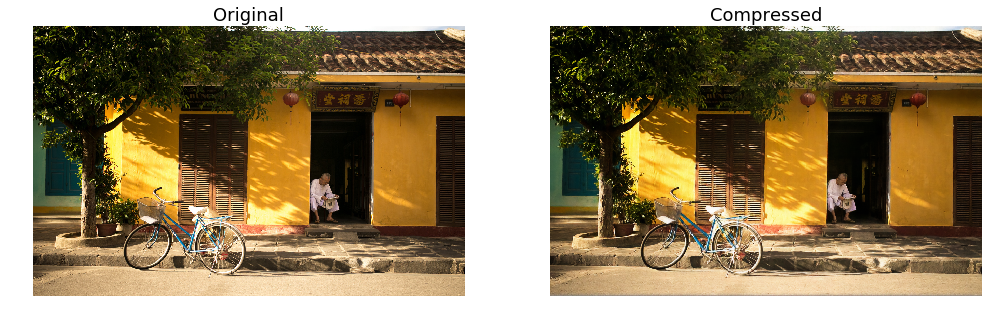

In [7]:
plt.figure(figsize=(17, 8))
plt.subplot(121)
plt.imshow(train_img_1)
plt.title("Original", fontsize=18)
plt.axis("off")

plt.subplot(122)
plt.title("Compressed", fontsize=18)
plt.imshow(tf.squeeze(encoded_1).numpy())
plt.axis("off")

plt.show()

In [7]:
from imageio import imwrite

clipped = np.squeeze(encoded_1.numpy())
clipped[clipped > 1] = 1
clipped[clipped < 0] = 0

clipped *= 255

clipped = clipped.astype(np.uint8)

im_path = "/homes/gf332/miracle-compession/img/clic/thong_vo_residual_ladder.png"

if not os.path.exists(im_path):
    imwrite(im_path, clipped)
else:
    print("{} already exists".format(im_path))

# Get results on the whole CLIC validation dataset

In [8]:
valid_image_dir = "/home/gf332/.keras/datasets/miracle_image_compression/valid"
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

results = []

with tf.device("CPU:0"):
    for im_path in tqdm(valid_image_paths):

        image = tf.convert_to_tensor(load_and_process_image(valid_image_paths[0]))[None, ...]

        reconstruction = vae(image)
        reconstruction = tf.clip_by_value(reconstruction, 0., 1.)

        ms_ssim = tf.image.ssim_multiscale(tf.convert_to_tensor(image), reconstruction, 1.).numpy()[0]
        psnr = tf.image.psnr(image, reconstruction, max_val=1.0).numpy()[0]

        results.append((im_path, ms_ssim, psnr))

In [26]:
paths, ssims, psnrs = zip(*results)

ssim_mean = np.mean(ssims)
ssim_std = np.std(ssims)

psnrs_mean = np.mean(psnrs)
psnrs_std = np.std(psnrs)

print("MS-SSIM: {:.4f} \pm {:.4f}".format(ssim_mean, ssim_std))
print("PSNR: {:.2f} \pm {:.4f}".format(psnrs_mean, psnrs_std))

MS-SSIM: 0.9667 \pm 0.0001
PSNR: 32.49 \pm 0.0054


# Actual Compression bit, for real this time

In [9]:
valid_image_dir = "/scratch/gf332/datasets/miracle_image_compression/valid"
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

with tf.device("CPU:0"):
    
    im = load_and_process_image(valid_image_paths[4])
    im = tf.convert_to_tensor(train_img_1[None, ...])
    latents = vae.encode(im)
    
    res = vae.decode(latents)

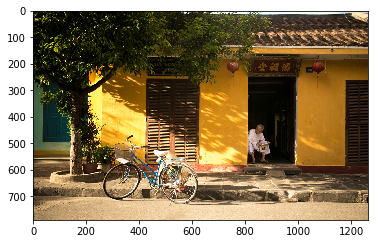

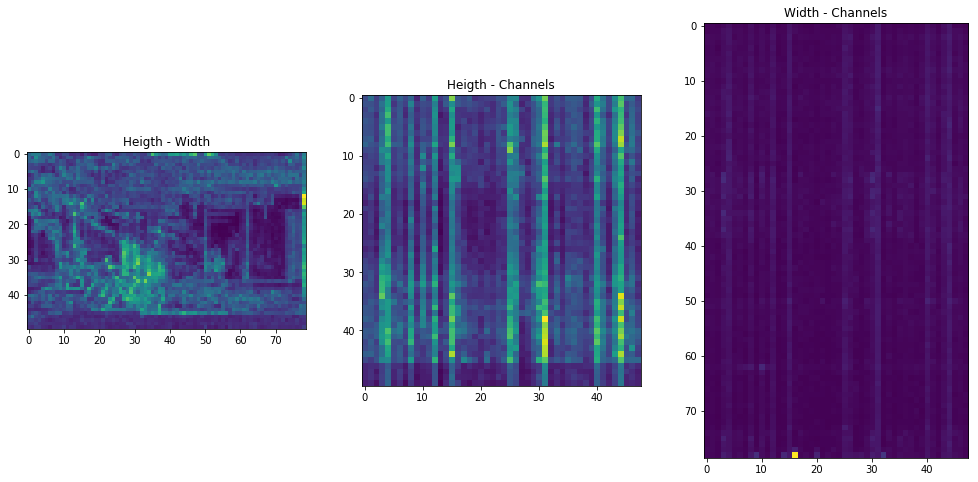

In [10]:
kl_1 = vae.kl_divergence[0][0]
kl_2 = vae.kl_divergence[1][0]

kl_1_hw = tf.reduce_sum(kl_1, axis=2)
kl_1_hc = tf.reduce_sum(kl_1, axis=1)
kl_1_wc = tf.reduce_sum(kl_1, axis=0)


plt.imshow(tf.squeeze(im))

plt.figure(figsize=(17, 8))
plt.subplot(131)
plt.title("Heigth - Width")
plt.imshow(kl_1_hw, interpolation="nearest", aspect="equal", origin="upper")

plt.subplot(132)
plt.title("Heigth - Channels")
plt.imshow(kl_1_hc, interpolation="nearest", aspect="equal", origin="upper")

plt.subplot(133)
plt.title("Width - Channels")
plt.imshow(kl_1_wc, interpolation="nearest", aspect="equal", origin="upper")



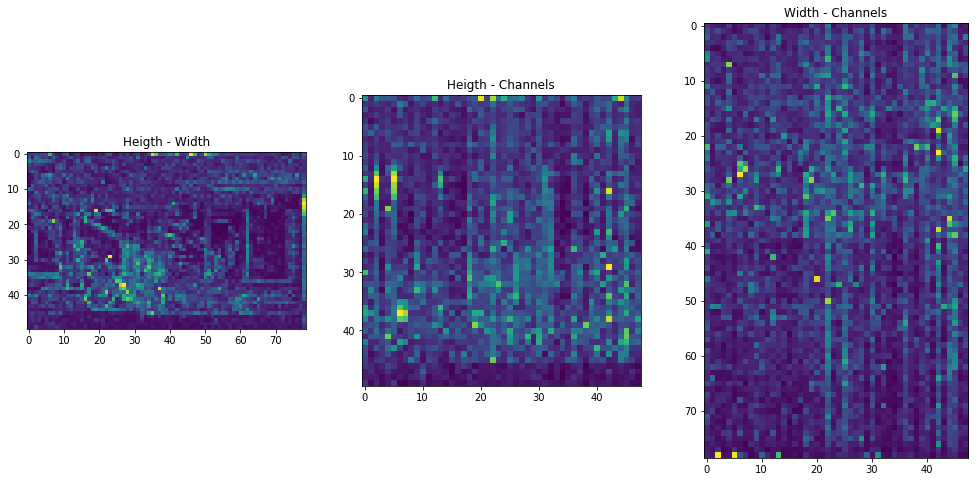

In [38]:
kl_1_hw = tf.reduce_max(kl_1, axis=2)
kl_1_hc = tf.reduce_max(kl_1, axis=1)
kl_1_wc = tf.reduce_max(kl_1, axis=0)

plt.figure(figsize=(17, 8))
plt.subplot(131)
plt.title("Heigth - Width")
plt.imshow(kl_1_hw, interpolation="nearest", aspect="equal", origin="upper")

plt.subplot(132)
plt.title("Heigth - Channels")
plt.imshow(kl_1_hc, interpolation="nearest", aspect="equal", origin="upper")

plt.subplot(133)
plt.title("Width - Channels")
plt.imshow(kl_1_wc, interpolation="nearest", aspect="equal", origin="upper")

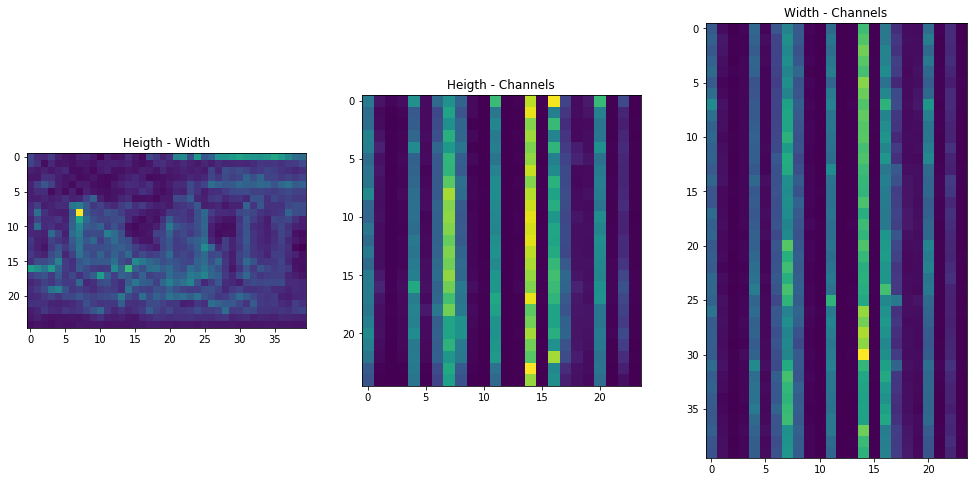

In [39]:
kl_2_hw = tf.reduce_sum(kl_2, axis=2)
kl_2_hc = tf.reduce_sum(kl_2, axis=1)
kl_2_wc = tf.reduce_sum(kl_2, axis=0)

plt.figure(figsize=(17, 8))
plt.subplot(131)
plt.title("Heigth - Width")
plt.imshow(kl_2_hw, interpolation="nearest", aspect="equal", origin="upper")

plt.subplot(132)
plt.title("Heigth - Channels")
plt.imshow(kl_2_hc, interpolation="nearest", aspect="equal", origin="upper")

plt.subplot(133)
plt.title("Width - Channels")
plt.imshow(kl_2_wc, interpolation="nearest", aspect="equal", origin="upper")

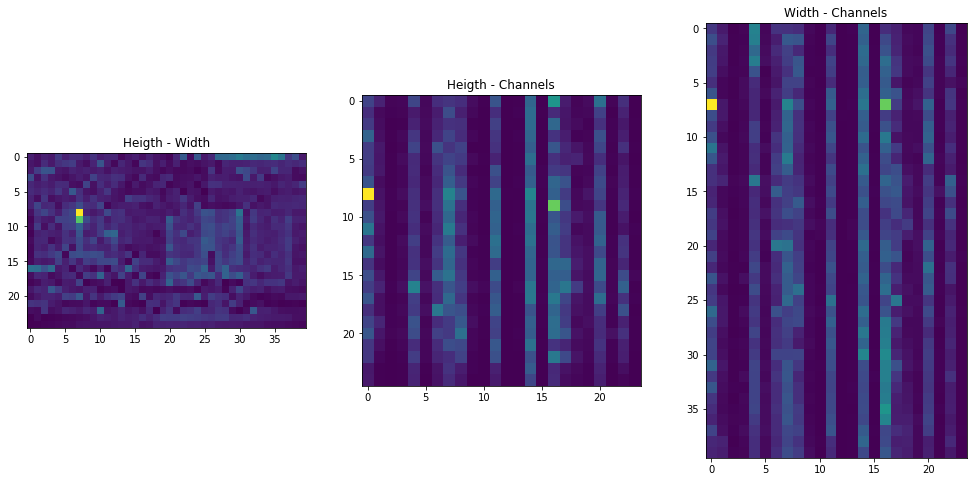

In [40]:
kl_2_hw = tf.reduce_max(kl_2, axis=2)
kl_2_hc = tf.reduce_max(kl_2, axis=1)
kl_2_wc = tf.reduce_max(kl_2, axis=0)

plt.figure(figsize=(17, 8))
plt.subplot(131)
plt.title("Heigth - Width")
plt.imshow(kl_2_hw, interpolation="nearest", aspect="equal", origin="upper")

plt.subplot(132)
plt.title("Heigth - Channels")
plt.imshow(kl_2_hc, interpolation="nearest", aspect="equal", origin="upper")

plt.subplot(133)
plt.title("Width - Channels")
plt.imshow(kl_2_wc, interpolation="nearest", aspect="equal", origin="upper")

In [14]:
seed = 42
miracle_bits = 8

coded_samps = coded_sample(proposal=vae.latent_priors[1], 
                           target=vae.latent_posteriors[1], 
                           seed=seed, 
                           n_points=30, 
                           miracle_bits=miracle_bits,
                           outlier_mode="importance_sample")

100%|██████████| 256/256 [00:04<00:00, 52.25it/s]

Accepted 99.03% of samples, 639.0 latents not accepted.


In [6]:
from compression import rejection_sample

seed = 42
miracle_bits = 8

result = rejection_sample(p=vae.latent_priors[1],
                          q=vae.latent_posteriors[1],
                          n_points=30,
                          num_draws=2**miracle_bits,
                          calculate_importance_weights=True,
                          seed=seed)

W0708 14:52:00.457897 140506635159296 deprecation_wrapper.py:119] From /homes/gf332/miracle-compession/code/clic/compression.py:34: The name tf.random.set_random_seed is deprecated. Please use tf.compat.v1.random.set_random_seed instead.

W0708 14:52:00.932274 140506635159296 deprecation.py:323] From /homes/gf332/miracle-compession/miracle_venv/lib/python3.5/site-packages/tensorflow_probability/python/internal/special_math.py:251: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
100%|██████████| 256/256 [00:01<00:00, 170.64it/s]


In [7]:
tf.reduce_max(result[3])

<tf.Tensor: id=26887, shape=(), dtype=float32, numpy=255.0>

In [10]:
decoded_samps = decode_sample(coded_sample=coded_samps,
                              proposal=vae.latent_priors[1], 
                              seed=seed, 
                              n_points=30, 
                              miracle_bits=miracle_bits, 
                              outlier_mode="quantize")

100%|██████████| 256/256 [00:00<00:00, 473.54it/s]


In [11]:
coded_samps_ = coded_sample(proposal=vae.latent_priors[0], 
                           target=vae.latent_posteriors[0], 
                           seed=seed, 
                           n_points=30, 
                           miracle_bits=miracle_bits)

100%|██████████| 256/256 [00:37<00:00,  7.01it/s]

Accepted 99.59% of samples, 2153.0 latents not accepted.


In [12]:
decoded_samps_ = decode_sample(coded_sample=coded_samps_,
                              proposal=vae.latent_priors[0], 
                              seed=seed, 
                              n_points=30, 
                              miracle_bits=miracle_bits, 
                              outlier_mode="quantize")

100%|██████████| 256/256 [00:00<00:00, 326.79it/s]


In [13]:
unique, _, counts = tf.unique_with_counts(coded_samps)


unique = unique.numpy()
counts = counts.numpy()

np.all((coded_samps < 256).numpy() == accepted.numpy())

NameError: name 'accepted' is not defined

<BarContainer object of 255 artists>

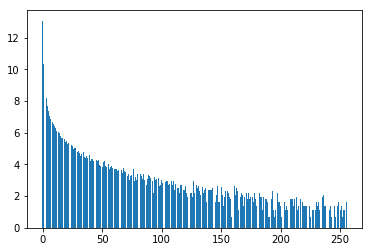

In [87]:
plt.bar(unique[unique < 256], np.log(counts[unique < 256]))

In [10]:
latent_shape_ = vae.latent_priors[0].loc.shape.as_list()
latent_shape = vae.latent_priors[1].loc.shape.as_list()
latent_shape_

[1, 86, 128, 64]

In [9]:
with tf.device("CPU:0"):
    decoded = vae.decode(latents)
#     decoded_ = tf.nn.sigmoid(vae.decode((tf.reshape(decoded_samps, latent_shape), 
#                                          tf.reshape(decoded_samps_, latent_shape_))))
    

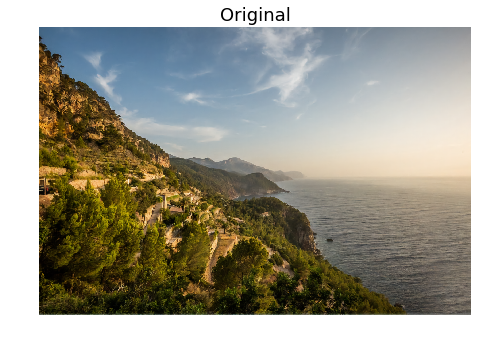

In [10]:
plt.figure(figsize=(17, 8))
plt.subplot(121)
plt.imshow(tf.squeeze(decoded).numpy())
plt.title("Original", fontsize=18)
plt.axis("off")

# plt.subplot(122)
# plt.title("Compressed", fontsize=18)
# plt.imshow(tf.squeeze(decoded_).numpy())
# plt.axis("off")

plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt

prob_mass = np.load("../../probability_mass_48_24.npy")

total_mass = np.sum(prob_mass)

log_prob_mass = np.log(prob_mass)

log_total_mass = np.log(total_mass)

<BarContainer object of 256 artists>

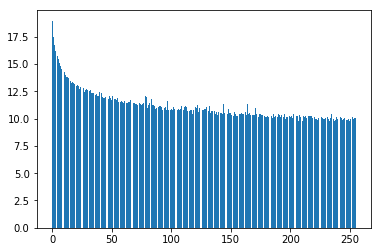

In [10]:
plt.bar(np.arange(len(prob_mass)), np.log(prob_mass))

In [20]:
log_prob_mass[0] - log_total_mass

-0.11732173697385306

In [12]:
100 * 2**16 / np.sum(prob_mass)

0.012697403590212564

In [7]:
num_bits = 2**16
gamma = 100

P = gamma * np.ones(num_bits)


In [7]:
valid_image_dir = "/scratch/gf332/datasets/miracle_image_compression/valid"
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

with tf.device("CPU:0"):
    for i, im_path in enumerate(valid_image_paths):
        
        im = load_and_process_image(im_path)
        print(i, im_path, im.shape)

0 /scratch/gf332/datasets/miracle_image_compression/valid/stefan-kunze-26931.png (1367, 2048, 3)
1 /scratch/gf332/datasets/miracle_image_compression/valid/sergey-zolkin-1045.png (1365, 2048, 3)
2 /scratch/gf332/datasets/miracle_image_compression/valid/wojciech-szaturski-3611.png (1325, 1988, 3)
3 /scratch/gf332/datasets/miracle_image_compression/valid/juskteez-vu-1041.png (1725, 1145, 3)
4 /scratch/gf332/datasets/miracle_image_compression/valid/thong-vo-428.png (790, 1264, 3)
5 /scratch/gf332/datasets/miracle_image_compression/valid/ales-krivec-15949.png (1188, 2048, 3)
6 /scratch/gf332/datasets/miracle_image_compression/valid/amy-zhang-15940.png (915, 1632, 3)
7 /scratch/gf332/datasets/miracle_image_compression/valid/todd-quackenbush-27493.png (1033, 2048, 3)
8 /scratch/gf332/datasets/miracle_image_compression/valid/alejandro-escamilla-6.png (1339, 2048, 3)
9 /scratch/gf332/datasets/miracle_image_compression/valid/sergey-zolkin-21232.png (1028, 1542, 3)
10 /scratch/gf332/datasets/mira

W0721 15:34:11.957932 139902008366848 deprecation_wrapper.py:119] From /homes/gf332/miracle-compession/code/clic/compression.py:34: The name tf.random.set_random_seed is deprecated. Please use tf.compat.v1.random.set_random_seed instead.

W0721 15:34:11.967761 139902008366848 deprecation.py:323] From /homes/gf332/miracle-compession/miracle_venv/lib/python3.5/site-packages/tensorflow_probability/python/internal/special_math.py:251: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
100%|██████████| 256/256 [00:04<00:00, 52.56it/s]


Accepted 97.39% of samples, 627.0 latents not accepted.


100%|██████████| 256/256 [00:18<00:00, 13.75it/s]


Accepted 98.88% of samples, 2132.0 latents not accepted.
Outlier / Miracle Mass Ratio: 0.0069


 10%|▉         | 20888/213601 [00:00<00:00, 208871.24it/s]

Depth of symbol tree: 17


100%|██████████| 213601/213601 [00:00<00:00, 327107.26it/s]


Expected code length: 492974.02 bits
Actual code length: 711211 bits
[42, 30, 50, 79, 25, 40]
Outlier / Miracle Mass Ratio: 0.0069
Depth of symbol tree: 17
Remaining bits at end of code: -3


100%|██████████| 256/256 [00:01<00:00, 163.74it/s]


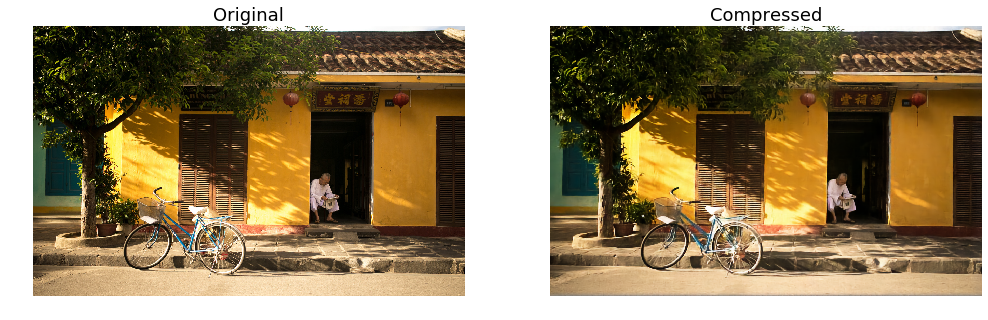

In [5]:
valid_image_dir = "/scratch/gf332/datasets/miracle_image_compression/valid"
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

comp_file_path = "thong_vo_quant_bad.miracle"

seed = 42
miracle_bits = 8
outlier_mode = "quantize"
gamma=30

probability_mass = np.load("../../probability_mass_48_24.npy")

with tf.device("CPU:0"):
    
    im = load_and_process_image(valid_image_paths[4])
    im = tf.convert_to_tensor(im[None, ...])
    vae.code_image(image=im,
                   seed=seed,
                   gamma=gamma,
                   miracle_bits=miracle_bits,
                   probability_mass=probability_mass,
                   comp_file_path=comp_file_path,
                   outlier_mode=outlier_mode,
                   verbose=True)
    
    reconstruction = vae.decode_image(comp_file_path=comp_file_path,
                                      probability_mass=probability_mass,
                                      miracle_bits=miracle_bits,
                                      outlier_mode=outlier_mode,
                                      verbose=True)
    
    
plt.figure(figsize=(17, 8))
plt.subplot(121)
plt.imshow(tf.squeeze(im).numpy())
plt.title("Original", fontsize=18)
plt.axis("off")

plt.subplot(122)
plt.title("Compressed", fontsize=18)
plt.imshow(tf.squeeze(reconstruction).numpy())
plt.axis("off")

plt.show()

# Miguel's method

In [5]:
valid_image_dir = "/scratch/gf332/datasets/miracle_image_compression/valid"
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

with tf.device("CPU:0"):
    
    im = load_and_process_image(valid_image_paths[22])
    latents = vae.encode(tf.convert_to_tensor(im[None, ...]))
    
    res = vae.decode(latents)

In [6]:
n_bits_per_step = 14
n_steps = 30
seed = 2
rho = 1.

# s1, c1, gi1 = code_grouped_greedy_sample(target=vae.latent_posteriors[1], 
#                                                          proposal=vae.latent_priors[1], 
#                                                          n_bits_per_step=n_bits_per_step, 
#                                                          n_steps=n_steps, 
#                                                          seed=seed, 
#                                                          max_group_size_bits=6,
#                                                          adaptive=True,
#                                                          backfitting_steps=0,
#                                                          rho=rho)

# s1_ = decode_grouped_greedy_sample(c1,
#                                    gi1,
#                                    vae.latent_priors[1], 
#                                    n_bits_per_step, 
#                                    n_steps, 
#                                    seed,
#                                    adaptive=True,
#                                    rho=rho)
n_bits_per_group = 20
max_group_size_bits = 4
dim_kl_bit_limit = 12

# s1, c1, gi1, outlier_extras = code_grouped_importance_sample(target=vae.latent_posteriors[1], 
#                                                              proposal=vae.latent_priors[1], 
#                                                              n_bits_per_group=n_bits_per_group, 
#                                                              seed=seed, 
#                                                              max_group_size_bits=max_group_size_bits,
#                                                              dim_kl_bit_limit=dim_kl_bit_limit)

i, k = code_grouped_importance_sample(target=vae.latent_posteriors[1], 
                                                             proposal=vae.latent_priors[1], 
                                                             n_bits_per_group=n_bits_per_group, 
                                                             seed=seed, 
                                                             max_group_size_bits=max_group_size_bits,
                                                             dim_kl_bit_limit=dim_kl_bit_limit)


# s1_ = decode_grouped_importance_sample(bitcode=c1, 
#                                          group_start_indices=gi1[:-1],
#                                          proposal=vae.latent_priors[1], 
#                                          n_bits_per_group=n_bits_per_group,
#                                          seed=seed,
#                                          outlier_indices=outlier_extras[0],
#                                          outlier_samples=outlier_extras[1])


W0806 14:26:36.382615 139961967695616 deprecation.py:323] From /homes/gf332/miracle-compession/code/clic/greedy_compression.py:424: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Total KL to split up: 6041.93 bits, maximum bits per group: 20, estimated number of groups: 303.0,coding 4608 dimensions


In [11]:
np.all(s1_.numpy() == s1.numpy())

False

In [12]:
s1_r = tf.cast(tf.reshape(s1_, vae.latent_priors[1].loc.shape.as_list()), tf.float32)

print(s1_r.shape.as_list())
print(vae.latent_posteriors[1].sample().shape.as_list())

second_avg_log_lik = tf.reduce_mean(vae.latent_posteriors[1].log_prob(s1_r))
average_sample_lik = tf.reduce_mean(vae.latent_posteriors[1].log_prob(vae.latent_posteriors[1].sample()))

print("Avg greedy sample log likelihood on level 2: {:.4f}".format(second_avg_log_lik))
print("Avg sample log likelihood on level 2: {:.4f}".format(average_sample_lik))

[1, 12, 16, 24]
[1, 12, 16, 24]
Avg greedy sample log likelihood on level 2: -0.3879
Avg sample log likelihood on level 2: -0.2355


In [13]:
kl_divs = tf.reshape(tfd.kl_divergence(vae.latent_posteriors[0], vae.latent_priors[0]), [-1]).numpy()
total_kl_bits = np.sum(kl_divs) / np.log(2)
total_kl_bits

23259.21398212442

In [15]:
r = vae.decode((tf.reshape(s1_, vae.latent_priors[1].loc.shape.as_list()), tf.zeros_like(latents[1])))
#vae.decode(latents)
kl_divs = tf.reshape(tfd.kl_divergence(vae.latent_posteriors[0], vae.latent_priors[0]), [-1]).numpy()
total_kl_bits = np.sum(kl_divs) / np.log(2)
total_kl_bits

27038.745310894552

In [16]:
s2, c2, gi2 = code_grouped_greedy_sample(target=vae.latent_posteriors[0], 
                                         proposal=vae.latent_priors[0], 
                                         n_bits_per_step=n_bits_per_step, 
                                         n_steps=n_steps, 
                                         seed=seed, 
                                         max_group_size_bits=12, # group size limited to 2^max_group_size_bits
                                         backfitting_steps=0,
                                         adaptive=True)

  0%|          | 0/65 [00:00<?, ?it/s]

Total KL to split up: 27038.75 bits, maximum bits per group: 420, estimated number of groups: 65.0,coding 36864 dimensions


100%|██████████| 65/65 [00:19<00:00,  2.57it/s]


In [17]:
s2_ = decode_grouped_greedy_sample(c2,
                                   gi2,
                                   vae.latent_priors[0], 
                                   n_bits_per_step, 
                                   n_steps, 
                                   seed, 
                                   adaptive=True,
                                   rho=rho)

100%|██████████| 66/66 [00:06<00:00,  9.57it/s]


In [18]:
np.all(s2_.numpy() == s2.numpy())

True

In [19]:
s2_r = tf.cast(tf.reshape(s2_, vae.latent_priors[0].loc.shape.as_list()), tf.float32)
s1_r = tf.cast(tf.reshape(s1_, vae.latent_priors[1].loc.shape.as_list()), tf.float32)

print(s2_r.shape.as_list())
print(s1_r.shape.as_list())
print(vae.latent_posteriors[0].sample().shape.as_list())
print(vae.latent_posteriors[1].sample().shape.as_list())

r= vae(tf.convert_to_tensor(im[None, ...]))

first_avg_log_lik = tf.reduce_mean(vae.latent_posteriors[0].log_prob(s2_r))
second_avg_log_lik = tf.reduce_mean(vae.latent_posteriors[1].log_prob(s1_r))
first_sample_avg = tf.reduce_mean(vae.latent_posteriors[0].log_prob(vae.latent_posteriors[0].sample()))

print("Avg greedy sample log likelihood on level 1: {:.4f}".format(first_avg_log_lik))
print("Avg sample log likelihood on level 1: {:.4f}".format(first_sample_avg))
print("Avg greedy sample log likelihood on level 2: {:.4f}".format(second_avg_log_lik))

[1, 24, 32, 48]
[1, 12, 16, 24]
[1, 24, 32, 48]
[1, 12, 16, 24]
Avg greedy sample log likelihood on level 1: -0.1121
Avg sample log likelihood on level 1: -0.0266
Avg greedy sample log likelihood on level 2: -0.3879


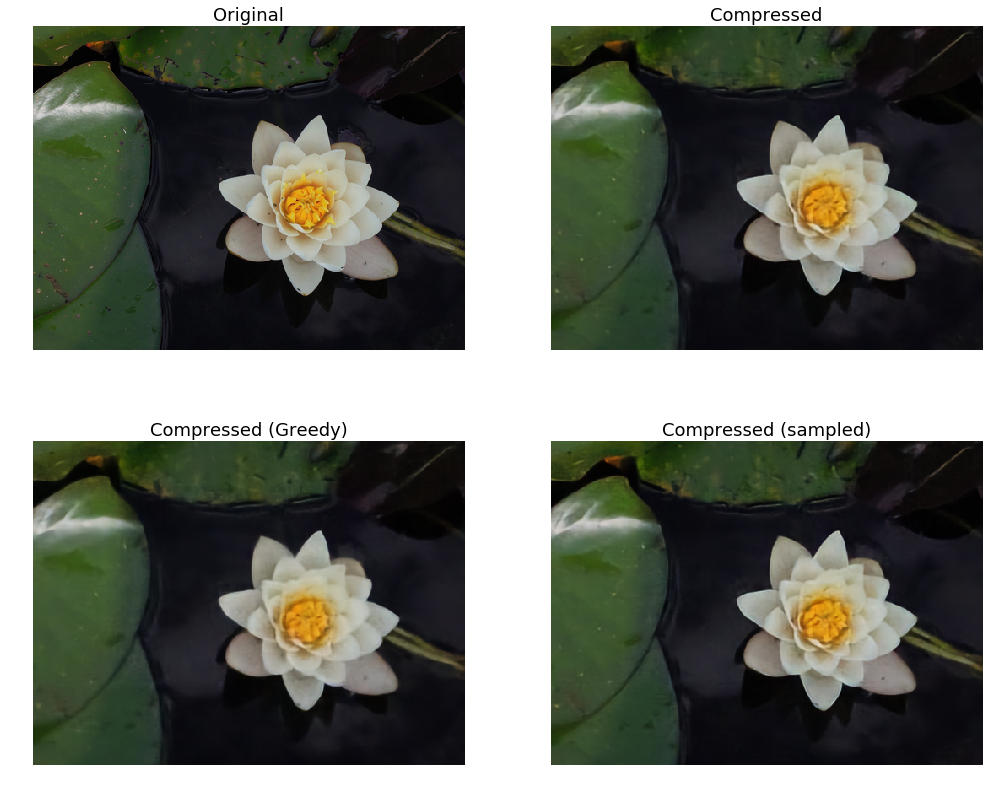

In [20]:
reconstruction = vae.decode((s1_r, s2_r))
mean_reconstruction = vae.decode((vae.latent_posteriors[1].loc, vae.latent_posteriors[0].sample()))

plt.figure(figsize=(17, 14))
plt.subplot(221)
plt.imshow(tf.squeeze(im).numpy())
plt.title("Original", fontsize=18)
plt.axis("off")

plt.subplot(222)
plt.title("Compressed", fontsize=18)
plt.imshow(tf.squeeze(res).numpy())
plt.axis("off")

plt.subplot(223)
plt.title("Compressed (Greedy)", fontsize=18)
plt.imshow(tf.squeeze(reconstruction).numpy())
plt.axis("off")

plt.subplot(224)
plt.title("Compressed (sampled)", fontsize=18)
plt.imshow(tf.squeeze(mean_reconstruction).numpy())
plt.axis("off")

plt.savefig("compression_comparison.png")

plt.show()

In [46]:
write_bin_code(c1, "miguel.miracle")

In [47]:
#vae(im[None, ...])
#total_kl = sum([tf.reduce_sum(x) for x in vae.kl_divergence])
total_kl = tf.reduce_sum(vae.kl_divergence[0])

theoretical_byte_size = (total_kl + 2 * np.log(total_kl + 1)) / np.log(2) / 8
actual = os.path.getsize("miguel.miracle") + (len(gi1) + len(gi2)) * 3

print("Theoretical size: {:.2f} bytes".format(theoretical_byte_size))
print("Actual size: {:.2f} bytes".format(actual))
print("Efficiency: {:.3f}".format(actual / theoretical_byte_size))

Theoretical size: 2849.59 bytes
Actual size: 4329.00 bytes
Efficiency: 1.519


In [ ]:
train_img_1.shape

# Miguel's Method, as it's supposed to be used

In [5]:
valid_image_dir = "/scratch/gf332/datasets/miracle_image_compression/valid"
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

comp_file_path = "lily_miguel.miracle"

n_bits_per_step = 14
n_steps = 30
seed = 1
rho = 1.
first_level_max_group_size_bits=12
second_level_max_group_size_bits=4

im = load_and_process_image(valid_image_paths[22])
im = tf.convert_to_tensor(im[None, ...])

samp2, samp1 = vae.code_image_greedy(image=im,
                                seed=seed,
                                rho=rho,
                                n_steps=n_steps,
                                n_bits_per_step=n_bits_per_step,
                                comp_file_path=comp_file_path,
                                backfitting_steps_level_1=0,
                                backfitting_steps_level_2=0,
                                use_log_prob=False,
                                first_level_max_group_size_bits=first_level_max_group_size_bits,
                                second_level_n_bits_per_group=20,
                                second_level_max_group_size_bits=second_level_max_group_size_bits,
                                second_level_dim_kl_bit_limit=12,
                                verbose=True)

r_no_back = vae.decode_image_greedy(comp_file_path=comp_file_path,
                                         verbose=True,
                                         rho=rho)

W0806 14:37:54.618648 139820255512320 deprecation.py:323] From /homes/gf332/miracle-compession/code/clic/greedy_compression.py:410: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
  0%|          | 0/385 [00:00<?, ?it/s]W0806 14:37:54.649934 139820255512320 deprecation_wrapper.py:119] From /homes/gf332/miracle-compession/code/clic/greedy_compression.py:349: The name tf.random.set_random_seed is deprecated. Please use tf.compat.v1.random.set_random_seed instead.

  2%|▏         | 7/385 [00:00<00:05, 65.33it/s]

Coding second level
Total KL to split up: 6041.93 bits, maximum bits per group: 20, estimated number of groups: 303.0,coding 4608 dimensions
Maximum group KL: 18.555


100%|██████████| 385/385 [00:04<00:00, 80.39it/s]


Coding first level
Total KL to split up: 43053.92 bits, maximum bits per group: 420, estimated number of groups: 103.0,coding 98304 dimensions


 12%|█▏        | 46/385 [00:00<00:00, 458.04it/s]

Image dimensions: [1, 384, 512, 3]
Theoretical size: 6158.16 bytes
Actual size: 6903.00 bytes
Extra information size: 366.00 bytes 5.30% of actual size
Actual size without extras: 6537.00 bytes
Efficiency: 1.121

First level theoretical size: 5385.46 bytes
First level actual (no extras) size: 5512.50 bytes
First level extras size: 159.00 bytes
First level Efficiency: 1.053
First level # of groups: 106
First level greedy sample average log likelihood: -0.2746
First level average sample log likelihood on level 1: -0.2120

Second level theoretical size: 775.67 bytes
Second level actual (no extras) size: 962.50 bytes
Second level extras size: 194.00 bytes
10 outliers were not compressed (higher than 12 bits of KL)
Second level Efficiency: 1.491
Second level's contribution to bpp: 0.0471
Second level # of groups: 386
Second level greedy sample average log likelihood: -0.6198
Second level average sample log likelihood on level 1: -0.4849

0.2809 bits / pixel
Decoding second level


  1%|          | 1/106 [00:00<00:14,  7.15it/s]

Decoding first level


100%|██████████| 106/106 [00:14<00:00,  7.15it/s]


In [7]:
q1_scale = tf.reshape(vae.latent_posteriors[0].scale, [-1]).numpy()
q2_scale = tf.reshape(vae.latent_posteriors[1].scale, [-1]).numpy()


q1_deviations = (tf.reshape(vae.latent_posteriors[0].loc, [-1]) - tf.squeeze(samp1)).numpy()
q2_deviations = (tf.reshape(vae.latent_posteriors[1].loc, [-1]) - tf.squeeze(samp2)).numpy()


num_bins = 200

plt.figure(figsize=(17, 17))
plt.subplot(221)
plt.title("First Level Standard Deviations")
plt.hist(q1_scale, bins=num_bins)

plt.subplot(222)
plt.title("Second Level Standard Deviations")
plt.hist(q2_scale, bins=num_bins)

plt.subplot(223)
plt.title("First Level Deviations from the Mean")
plt.hist(q1_deviations, bins=num_bins)

plt.subplot(224)
plt.title("Second Level Deviations from the Mean")
plt.hist(q2_deviations, bins=num_bins)

plt.show()

ValueError: Attempt to convert a value ({'image_shape': [1, 384, 512, 3], 'bpp': 0.6262613932291666, 'theoretical_byte_size': <tf.Tensor: id=447040, shape=(), dtype=float32, numpy=14349.259>, 'extra_byte_size': 652, 'actual_no_extra': 14739, 'second_bpp': 0.061808268229166664, 'actual_byte_size': 15391}) with an unsupported type (<class 'dict'>) to a Tensor.

Image dimensions: [1, 384, 512, 3]
Theoretical size: 4377.05 bytes
Actual size: 5047.00 bytes
Extra information size: 355.00 bytes 7.03% of actual size
Actual size without extras: 4692.00 bytes
Efficiency: 1.153

First level theoretical size: 3369.37 bytes
First level actual (no extras) size: 3412.50 bytes
First level extras size: 99.00 bytes
First level Efficiency: 1.042
First level # of groups: 66
First level greedy sample average log likelihood: -0.1005
First level average sample log likelihood on level 1: -0.0214

Second level theoretical size: 1010.70 bytes
Second level actual (no extras) size: 1207.50 bytes
Second level extras size: 242.00 bytes
12 outliers were not compressed (higher than 12 bits of KL)
Second level Efficiency: 1.434
Second level # of groups: 484
Second level greedy sample average log likelihood: -0.3960
Second level average sample log likelihood on level 1: -0.2428

0.2054 bits / pixel
Decoding second level

-----------------------------------

Image dimensions: [1, 384, 512, 3]
Theoretical size: 4383.89 bytes
Actual size: 5047.00 bytes
Extra information size: 355.00 bytes 7.03% of actual size
Actual size without extras: 4692.00 bytes
Efficiency: 1.151

First level theoretical size: 3376.21 bytes
First level actual (no extras) size: 3412.50 bytes
First level extras size: 99.00 bytes
First level Efficiency: 1.040
First level # of groups: 66
First level greedy sample average log likelihood: -0.0906
First level average sample log likelihood on level 1: -0.0230

Second level theoretical size: 1010.70 bytes
Second level actual (no extras) size: 1207.50 bytes
Second level extras size: 242.00 bytes
12 outliers were not compressed (higher than 12 bits of KL)
Second level Efficiency: 1.434
Second level # of groups: 484
Second level greedy sample average log likelihood: -0.3956
Second level average sample log likelihood on level 1: -0.2428

0.2054 bits / pixel
Decoding second level

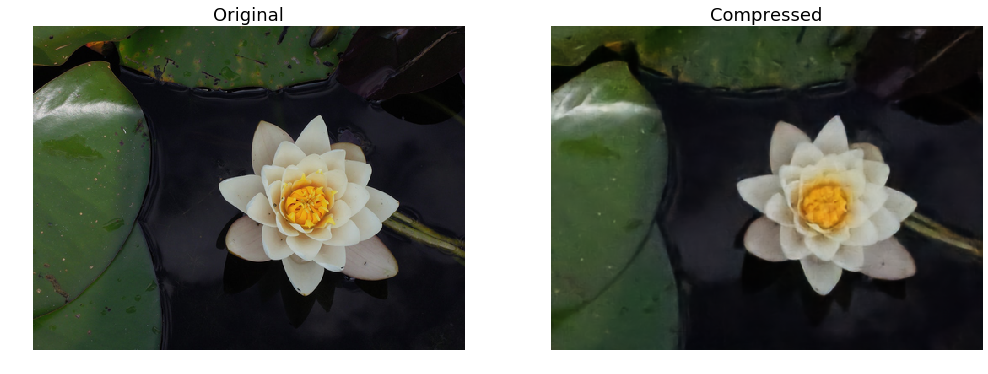

In [6]:
plt.figure(figsize=(17, 8))
plt.subplot(121)
plt.imshow(tf.squeeze(im).numpy())
plt.title("Original", fontsize=18)
plt.axis("off")

plt.subplot(122)
plt.title("Compressed", fontsize=18)
plt.imshow(r_no_back.numpy())
plt.axis("off")

plt.show()

In [12]:
!ls /homes/gf332/miracle-compession/config/clic/ladder/ladder_128_24_001.json

/homes/gf332/miracle-compession/config/clic/ladder/ladder_128_24_001.json


In [40]:
def baseline_compress_kodak(kodak_dataset_path,
                           reconstruction_root="../../data/kodak_miracle/",
                           n_kodak_images=24,
                           kodak_im_format="kodim{:02d}",
                           jpeg_quality_steps=7,
                           verbose=False):
  
    # Create lists of paths for every image in the dataset
    kodak_im_paths = [kodak_dataset_path + "/" + kodak_im_format.format(i) + ".png"
                      for i in range(1, n_kodak_images + 1)]

    # Load in the Kodak dataset
    kodak_paths_ds = tf.data.Dataset.from_tensor_slices(kodak_im_paths)
    kodak_ds = kodak_paths_ds.map(load_and_process_image)

    jpeg_max_quality = 95
    jpeg_min_quality = 1

    # --------------------------------------------------------------------------
    # Create JPEG baseline
    # --------------------------------------------------------------------------
    for j in range(jpeg_min_quality, jpeg_max_quality, jpeg_quality_steps):

        print("JPEG quality setting: {}".format(j))
        
        reconstruction_path = reconstruction_root + "/jpeg_{}".format(j)
        
        if not os.path.exists(reconstruction_path):
            print("Creating reconstruction directory " + reconstruction_path)

            os.makedirs(reconstruction_path)

        reconstruction_im_paths = [reconstruction_path + "/" + kodak_im_format.format(i) + ".jpg"
                                   for i in range(1, n_kodak_images + 1)]
            
        for i, kodak_im in tqdm(enumerate(kodak_ds), total=n_kodak_images):
            imwrite(reconstruction_im_paths[i], (255 * kodak_im).numpy().astype(np.uint8), quality=j)
            
    # --------------------------------------------------------------------------            
    # Create JPEG 2000 baseline
    # --------------------------------------------------------------------------    
#     for j in range(jpeg_min_quality, jpeg_max_quality, jpeg_quality_steps):

#         print("JPEG quality setting: {}".format(j))
        
#         reconstruction_path = reconstruction_root + "/jpeg_{}".format(j)
        
#         if not os.path.exists(reconstruction_path):
#             print("Creating reconstruction directory " + reconstruction_path)

#             os.makedirs(reconstruction_path)

#         reconstruction_im_paths = [reconstruction_path + "/" + kodak_im_format.format(i) + ".jpg"
#                                    for i in range(1, n_kodak_images + 1)]
            
#         for i, kodak_im in tqdm(enumerate(kodak_ds), total=n_kodak_images):
#             imwrite(reconstruction_im_paths[i], (255 * kodak_im).numpy().astype(np.uint8), quality=j)

In [ ]:
baseline_compress_kodak(kodak_dataset_path="/scratch/gf332/data/kodak",
                           reconstruction_root="/scratch/gf332/data/jpeg/",
                           n_kodak_images=24,
                           kodak_im_format="kodim{:02d}",
                           jpeg_quality_steps=7,
                           verbose=False)

# Convert Balle's stuff

In [2]:
# Define paths and header names
balle_mse_path = "/scratch/gf332/data/bmshj2018/mse/"
balle_mse_lambdas = [0.0015625, 0.003125, 0.00625, 0.0125, 0.025, 0.05, 0.1, 0.2]

balle_ssim_path = "/scratch/gf332/data/bmshj2018/msssim/"
balle_ssim_lambdas = [0.5, 1, 2, 4, 8, 16, 32, 64]

kodak_miracle_path = "/scratch/gf332/data/kodak_miracle/"

# Get datasets
kodak_ds = create_kodak_dataset()

balle_mse_ds, _ = create_kodak_comparison_dataset(comparison_dataset_path=balle_mse_path,
                                                  comparison_dataset_subdir="lambda")

balle_ssim_ds, _ = create_kodak_comparison_dataset(comparison_dataset_path=balle_ssim_path,
                                                   comparison_dataset_subdir="lambda")

# Read BPG information
mse_df = pd.read_csv(balle_mse_path + "/bpp.csv", 
                      header=None, 
                      names=["name"] + balle_mse_lambdas)

ssim_df = pd.read_csv(balle_ssim_path + "/bpp.csv", 
                      header=None, 
                      names=["name"] + balle_ssim_lambdas)

# Read in images and calculate psnrs and ms-ssims
to_psnr_and_ssim = lambda a, b: (tf.map_fn(lambda x: tf.image.ssim_multiscale(a, x, max_val=1.0), b),
                                 tf.map_fn(lambda x: tf.image.psnr(a, x, max_val=1.0), b))


comparison_ds = tf.data.Dataset.zip((kodak_ds,
                                     balle_mse_ds,
                                     balle_ssim_ds))

# Calculate MS-SSIM and PSNR for each reconstruction of the current image
kodak_info_ds = comparison_ds.map(
    lambda orig, mse, ssim: \
    (to_psnr_and_ssim(orig, mse),
     to_psnr_and_ssim(orig, ssim),
   ))

W0805 21:57:55.202348 140623207880448 deprecation_wrapper.py:119] From /homes/gf332/miracle-compession/code/clic/load_data.py:42: The name tf.read_file is deprecated. Please use tf.io.read_file instead.



In [3]:
kodak_im_format="kodim{:02d}.png"

# Create datasets similar to our stat format
balle_ssim_stats = {}
balle_psnr_stats = {}

for i, ((m_ssim, m_psnr), (s_ssim, s_psnr)) in tqdm(enumerate(kodak_info_ds), total=24):

    m_bpp = np.array(mse_df.iloc[i, 1:], dtype=np.float32).tolist()
    s_bpp = np.array(ssim_df.iloc[i, 1:], dtype=np.float32).tolist()
    
    m_ssim = m_ssim.numpy().tolist()
    m_psnr = m_psnr.numpy().tolist()
    
    s_ssim = s_ssim.numpy().tolist()
    s_psnr = s_psnr.numpy().tolist()
    
    balle_psnr_stats[kodak_im_format.format(i + 1)] = { header: {"bpp": bpp,
                                                                 "ms_ssim": ms_ssim,
                                                                 "psnr": psnr}
                                                       for header, bpp, ms_ssim, psnr 
                                                       in zip(balle_mse_lambdas, m_bpp, m_ssim, m_psnr)}
    
    balle_ssim_stats[kodak_im_format.format(i + 1)] = { header: {"bpp": bpp,
                                                                 "ms_ssim": ms_ssim,
                                                                 "psnr": psnr}
                                                       for header, bpp, ms_ssim, psnr 
                                                       in zip(balle_ssim_lambdas, s_bpp, s_ssim, s_psnr)}
    
balle_ssim_stat_path = balle_ssim_path + "/stats.json"
with open(balle_ssim_stat_path, "w") as json_file:
    json.dump(balle_ssim_stats, json_file)
    
balle_psnr_stat_path = balle_mse_path + "/stats.json"
with open(balle_psnr_stat_path, "w") as json_file:
    json.dump(balle_psnr_stats, json_file)

# Create stats for JPEG, JPEG2000 and BPG

In [4]:
# Define paths where the image directories can be found
jpeg_path = "/scratch/gf332/data/jpeg/"
#jpeg2k_path = "/scratch/gf332/data/jpeg2k"
bpg_path = "/scratch/gf332/data/bpg/"

# Load images
kodak_ds = create_kodak_dataset()

jpeg_ds, jpeg_paths_ds = create_kodak_comparison_dataset(jpeg_path, "*", kodak_im_format="/kodim{:02d}.jpg")
bpg_ds, bpg_paths_ds = create_kodak_comparison_dataset(bpg_path, "*")

# Read in images and calculate psnrs and ms-ssims
to_psnr_and_ssim = lambda a, b: (tf.map_fn(lambda x: tf.image.ssim_multiscale(a, x, max_val=1.0), b),
                                 tf.map_fn(lambda x: tf.image.psnr(a, x, max_val=1.0), b))


comparison_ds = tf.data.Dataset.zip((kodak_ds,
                                     jpeg_ds,
                                     bpg_ds,
                                     jpeg_paths_ds,
                                     bpg_paths_ds
                                    ))

# Calculate MS-SSIM and PSNR for each reconstruction of the current image
kodak_info_ds = comparison_ds.map(
    lambda orig, jpeg, bpg, jpeg_paths, bpg_paths: \
    (to_psnr_and_ssim(orig, jpeg),
     to_psnr_and_ssim(orig, bpg),
     jpeg_paths,
     bpg_paths
   ))

In [5]:
kodak_image_size = 768 * 512

kodak_im_format="kodim{:02d}.png"

# # Create datasets similar to our stat format
jpeg_stats = {}
bpg_stats = {}


for i, ((jpeg_ssim, jpeg_psnr), 
        (bpg_ssim, bpg_psnr), 
        jpeg_paths,
        bpg_paths) in tqdm(enumerate(kodak_info_ds), total=24):
    
    jpeg_headers = [str(jpeg_path.numpy()).split("/")[-2] for jpeg_path in jpeg_paths]
    bpg_headers = [str(bpg_path.numpy()).split("/")[-2] for bpg_path in bpg_paths]

    jpeg_bpps = [8 * os.path.getsize(os.path.splitext(j.numpy())[0] + b".jpg")  / kodak_image_size
                 for j in jpeg_paths]
    
    bpg_bpps = [8 * os.path.getsize(os.path.splitext(j.numpy())[0] + b".bpg")  / kodak_image_size
                 for j in bpg_paths]
    
    
    jpeg_ssim = jpeg_ssim.numpy().tolist()
    jpeg_psnr = jpeg_psnr.numpy().tolist()
    
    bpg_ssim = bpg_ssim.numpy().tolist()
    bpg_psnr = bpg_psnr.numpy().tolist()
    
    jpeg_stats[kodak_im_format.format(i + 1)] = { header: {"bpp": bpp,
                                                           "ms_ssim": ms_ssim,
                                                           "psnr": psnr}
                                                 for header, bpp, ms_ssim, psnr 
                                                 in zip(jpeg_headers, jpeg_bpps, jpeg_ssim, jpeg_psnr)}
    
    bpg_stats[kodak_im_format.format(i + 1)] = { header: {"bpp": bpp,
                                                          "ms_ssim": ms_ssim,
                                                          "psnr": psnr}
                                                for header, bpp, ms_ssim, psnr 
                                                in zip(bpg_headers, bpg_bpps, bpg_ssim, bpg_psnr)}

jpeg_stat_path = jpeg_path + "/stats.json"
with open(jpeg_stat_path, "w") as json_file:
    json.dump(jpeg_stats, json_file)
    
bpg_stat_path = bpg_path + "/stats.json"
with open(bpg_stat_path, "w") as json_file:
    json.dump(bpg_stats, json_file)

# Plot stuff for the thesis

In [95]:
# Define stats file paths
balle_psnr_stats_path = "/scratch/gf332/data/bmshj2018/mse/stats.json"
balle_ssim_stats_path = "/scratch/gf332/data/bmshj2018/msssim/stats.json"
jpeg_stats_path = "/scratch/gf332/data/jpeg/stats.json"
#jpeg2k_path = "/scratch/gf332/data/jpeg2k"
bpg_stats_path = "/scratch/gf332/data/bpg/stats.json"

# This one is special
miracle_stats_path = "/scratch/gf332/data/kodak_miracle/stats.json"

ladder_regex = "^ladder[_\d]*(?!gamma)$"
theo_ladder_regex = "^theoretical_ladder[_\d]*(?!gamma)$"

gamma_regex = "^ladder.*gamma$"
theo_gamma_regex = "^theoretical.*gamma$"

balle_psnr_stats = pd.read_json(balle_psnr_stats_path)
balle_ssim_stats = pd.read_json(balle_ssim_stats_path)
jpeg_stats = pd.read_json(jpeg_stats_path)
bpg_stats = pd.read_json(bpg_stats_path)

miracle_stats = pd.read_json(miracle_stats_path)

In [100]:
t = pd.read_json(miracle_stats["kodim05.png"].to_json()).transpose()
lad = t.filter(regex=gamma_regex, axis="index")

lad

actual_byte_size actual_no_extra       bpp  \
ladder_128_24_01_learn_log_gamma           201217          194457   4.09377   
ladder_128_24_10_learn_log_gamma             9294            8752  0.189087   
ladder_128_24_1_learn_log_gamma             56340           54321   1.14624   
ladder_128_24_3_learn_log_gamma             28111           26969   0.57192   

                                     decoding_time     encoding_time  \
ladder_128_24_01_learn_log_gamma  [164.3588953018]  [519.9210138321]   
ladder_128_24_10_learn_log_gamma   [28.5706911087]   [74.4516820908]   
ladder_128_24_1_learn_log_gamma    [57.9889872074]  [177.8979799747]   
ladder_128_24_3_learn_log_gamma    [40.1049096584]  [126.0337405205]   

                                 extra_byte_size       image_shape   ms_ssim  \
ladder_128_24_01_learn_log_gamma            6760  [1, 512, 768, 3]   0.97933   
ladder_128_24_10_learn_log_gamma             542  [1, 512, 768, 3]  0.824586   
ladder_128_24_1_learn_log_gamma             2019  [1, 512, 768, 3]  0.969486   
ladder_128_24_3_learn_log_gamma             1142  [1, 512, 768, 3]  0.936705   

                                     psnr second_bpp theoretical_byte_size  \
ladder_128_24_01_learn_log_gamma  28.3339   0.179657                184537   
ladder_128_24_10_learn_log_gamma   21.068  0.0395203               7996.09   
ladder_128_24_1_learn_log_gamma   26.8066  0.0644226               53303.2   
ladder_128_24_3_learn_log_gamma   24.3972  0.0511678               26280.7   

                                 total_time  
ladder_128_24_01_learn_log_gamma     684.28  
ladder_128_24_10_learn_log_gamma    103.022  
ladder_128_24_1_learn_log_gamma     235.887  
ladder_128_24_3_learn_log_gamma     166.139

## plots

In [92]:
kodak_image_size = 768 * 512

def gen_plots(which, 
              show=False, 
              test=False, 
              kodak_im_format="kodim{:02d}",
              comparison_plot_dir="../../img/plots/kodak_comparison/",
              coding_time_plot_dir="../../img/plots/kodak_coding_time/",
              side_info_plot_dir="../../img/plots/kodak_side_info/",
              print_table=False,
              label_fontsize=14,
              title_fontsize=18,
              legend_fontsize=12):
    
    ssim_to_db = lambda ssim: -10 * np.log(1 - ssim) / np.log(10)

    # the columns of miracle_stats are the Kodak images
    for idx, image in enumerate(miracle_stats):

        miracle_im_stats = pd.read_json(miracle_stats[image].to_json()).transpose()

        # Separate various datasets
        ladder_stats = miracle_im_stats.filter(regex=ladder_regex, axis="index")
        theo_ladder_stats = miracle_im_stats.filter(regex=theo_ladder_regex, axis="index")
        gamma_stats = miracle_im_stats.filter(regex=gamma_regex, axis="index")
        theo_gamma_stats = miracle_im_stats.filter(regex=theo_gamma_regex, axis="index")
        
        # Convert some of the fields in advance
        ladder_stats.loc[:, "bpp"] = ladder_stats.loc[:, "bpp"].apply(pd.to_numeric)
        ladder_stats.loc[:, "second_bpp"] = ladder_stats.loc[:, "second_bpp"].apply(pd.to_numeric)
        ladder_stats.loc[:, "encoding_time"] = ladder_stats.loc[:, "encoding_time"].apply(lambda x: x[0])
        ladder_stats.loc[:, "decoding_time"] = ladder_stats.loc[:, "decoding_time"].apply(lambda x: x[0])

        gamma_stats.loc[:, "bpp"] = gamma_stats.loc[:, "bpp"].apply(pd.to_numeric)
        gamma_stats.loc[:, "second_bpp"] = gamma_stats.loc[:, "second_bpp"].apply(pd.to_numeric)
        gamma_stats.loc[:, "encoding_time"] = gamma_stats.loc[:, "encoding_time"].apply(lambda x: x[0])
        gamma_stats.loc[:, "decoding_time"] = gamma_stats.loc[:, "decoding_time"].apply(lambda x: x[0])

        # Create image specific datasets
        balle_psnr_im_stats = pd.read_json(balle_psnr_stats[image].to_json()).transpose()
        balle_ssim_im_stats = pd.read_json(balle_ssim_stats[image].to_json()).transpose()
        jpeg_im_stats = pd.read_json(jpeg_stats[image].to_json()).transpose()
        bpg_im_stats = pd.read_json(bpg_stats[image].to_json()).transpose()

        # We will transform these in the same ways for consistency
        im_stats = [
            ladder_stats,
            theo_ladder_stats,
            gamma_stats,
            theo_gamma_stats,

            balle_psnr_im_stats,
            balle_ssim_im_stats,
            jpeg_im_stats,
            bpg_im_stats
        ]

        # Labels to be used on plots
        im_stat_labels = [
            "Miracle PLN",
            "Theoretical PLN",
            "Miracle $\gamma$-PLN",
            "Theoretical $\gamma$-PLN",

            "Ballé MSE",
            "Ballé MS-SSIM",
            "JPEG",
            "BPG 4:4:4"
        ]

        # Sort by bpp
        im_stats = [s.sort_values(by="bpp") for s in im_stats]
        
        # ====================================================================================
        # Comparison Plots
        # ====================================================================================

        # Map MS-SSIM to dB
        for im_stat in im_stats:
            im_stat["ms_ssim"] = im_stat["ms_ssim"].apply(ssim_to_db)


        sns.set_style("whitegrid")
        
        if "comparison" in which:
            
            sns.set_palette("bright")
            
            
            # Create figure
            plt.figure(figsize=(16, 16))
            plt.subplots_adjust(left=0.05, bottom=0.03, right=0.98, top=0.97, wspace=0.02, hspace=0.2)
            # ------------------------------------------------------------------------------------
            # MS-SSIM plot
            # ------------------------------------------------------------------------------------
            plt.subplot(211)
            plt.title("MS-SSIM comparison for " + kodak_im_format.format(idx + 1), 
                      fontsize=title_fontsize)

            for im_stat, im_stat_label in zip(im_stats, im_stat_labels):
                plt.plot(im_stat["bpp"], im_stat["ms_ssim"], marker='x', label=im_stat_label)

            plt.xlabel("Bits / Pixel", fontsize=label_fontsize)
            plt.ylabel("MS-SSIM (dB)", fontsize=label_fontsize)
            plt.grid(True)

            plt.legend(fontsize=legend_fontsize)

            # ------------------------------------------------------------------------------------
            # PSNR plot
            # ------------------------------------------------------------------------------------
            plt.subplot(212)
            plt.title("PSNR comparison for " + kodak_im_format.format(idx + 1), fontsize=title_fontsize)

            for im_stat, im_stat_label in zip(im_stats, im_stat_labels):
                plt.plot(im_stat["bpp"], im_stat["psnr"], marker='x', label=im_stat_label)

            plt.xlabel("Bits / Pixel", fontsize=label_fontsize)
            plt.ylabel("PSNR (dB)", fontsize=label_fontsize)
            plt.grid(True)

            plt.legend(fontsize=legend_fontsize)

            if not os.path.exists(comparison_plot_dir):
                os.makedirs(comparison_plot_dir) 
                
            plt.savefig(comparison_plot_dir + kodak_im_format.format(idx + 1) + "_comparison.png")

            if show:
                plt.show()

            plt.close()

        # ====================================================================================
        # Coding Time Plots
        # ====================================================================================

        if "coding_time" in which:
            
            sns.set_palette("muted")
            
            ladder_stats = im_stats[0]
            gamma_stats = im_stats[2]

            plt.figure(figsize=(14, 5))
            plt.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.90, wspace=0.2, hspace=0)
            # Ladder coding times
            plt.subplot(121)
            plt.title("PLNs for $ \\beta = \{1, 0.3, 0.1, 0.03\} $", fontsize=title_fontsize)
            plt.stackplot(ladder_stats["bpp"],
                          ladder_stats[["encoding_time", "decoding_time"]].transpose(), 
                          labels=("Encoding Time", "Decoding Time"))
            
            plt.vlines(ladder_stats["bpp"], ymin=0, ymax=300, color='k', linestyle="--", label="Actual Models")
            
            plt.legend(fontsize=legend_fontsize)

            plt.xlabel("Bits Per Pixel", fontsize=label_fontsize)
            plt.ylabel("Time (seconds)", fontsize=label_fontsize)

            plt.ylim([0, 300])
            
            # Gamma-Ladder coding times
            plt.subplot(122)
            plt.title("$\gamma$-PLNs for $\\beta = \{10, 3, 1, 0.1 \}$", fontsize=title_fontsize)
            plt.stackplot(gamma_stats["bpp"],
                          gamma_stats[["encoding_time", "decoding_time"]].transpose(), 
                          labels=("Encoding Time", "Decoding Time"))
            
            plt.vlines(gamma_stats["bpp"], ymin=0, ymax=800, color='k', linestyle="--", label="Actual Models")
            
            plt.legend(fontsize=legend_fontsize)

            plt.xlabel("Bits Per Pixel", fontsize=label_fontsize)
            plt.ylabel("Time (seconds)", fontsize=label_fontsize)

            plt.ylim([0, 800])
            
            if not os.path.exists(coding_time_plot_dir):
                os.makedirs(coding_time_plot_dir) 
                
            plt.savefig(coding_time_plot_dir + kodak_im_format.format(idx + 1) + "_coding_time.png")
            
            # Print the tabular LateX code for this
            if print_table:
                
                
                ladder_tab = ladder_stats[["encoding_time", "decoding_time"]].transpose()
                
                enc_times = [ladder_tab[model]["encoding_time"] for model in ladder_tab]
                enc_times = map(lambda x: "{:.2f}".format(x), enc_times)
                
                dec_times = [ladder_tab[model]["decoding_time"] for model in ladder_tab]
                dec_times = map(lambda x: "{:.2f}".format(x), dec_times)
                
                print(' & '.join(enc_times) + " \\\\ \\hline")
                print(' & '.join(dec_times) + " \\\\ \\hline")
                
                gamma_tab = gamma_stats[["encoding_time", "decoding_time"]].transpose()
                
                enc_times = [gamma_tab[model]["encoding_time"] for model in gamma_tab]
                enc_times = map(lambda x: "{:.2f}".format(x), enc_times)
                
                dec_times = [gamma_tab[model]["decoding_time"] for model in gamma_tab]
                dec_times = map(lambda x: "{:.2f}".format(x), dec_times)
                
                print(' & '.join(enc_times) + " \\\\ \\hline")
                print(' & '.join(dec_times) + " \\\\ \\hline")
            
            if show:
                plt.show()
                
            plt.close()

        # ====================================================================================
        # Side information Plots
        # ====================================================================================    
        
        if "side_info" in which:
            
            sns.set_palette("muted")
            
            ladder_stats = im_stats[0]
            gamma_stats = im_stats[2]
            
            plt.figure(figsize=(14, 5))
            plt.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.95, wspace=0.2, hspace=0)
            # Raw Comparison
            plt.subplot(121)
            
            plt.plot(ladder_stats["bpp"], ladder_stats["second_bpp"], marker='o', label="PLN")
            plt.plot(gamma_stats["bpp"], gamma_stats["second_bpp"], marker='o', label="$\gamma$-PLN")
            
            plt.legend(fontsize=legend_fontsize)

            plt.xlabel("Bits Per Pixel", fontsize=label_fontsize)
            plt.ylabel("Bits Per Pixel from 2nd Level", fontsize=label_fontsize)
            
            plt.grid(True)
            
            
            # Percentage Comparison
            plt.subplot(122)
            
            plt.plot(ladder_stats["bpp"], 
                     100 * ladder_stats["second_bpp"] / ladder_stats["bpp"], 
                     marker='o', 
                     label="PLN")
            
            plt.plot(gamma_stats["bpp"], 
                     100* gamma_stats["second_bpp"] / gamma_stats["bpp"], 
                     marker='o', 
                     label="$\gamma$-PLN")
            
            plt.legend(fontsize=legend_fontsize)

            plt.xlabel("Bits Per Pixel", fontsize=label_fontsize)
            plt.ylabel("Bits Per Pixel from 2nd Level (%)", fontsize=label_fontsize)
            
            plt.grid(True)
            
            if not os.path.exists(side_info_plot_dir):
                os.makedirs(side_info_plot_dir)  
                
            plt.savefig(side_info_plot_dir + kodak_im_format.format(idx + 1) + "_side_info.png")
            
            if show:
                plt.show()
                
            plt.close()
        
        # If we are testing, plot only for kodim01
        if test:
            break

In [94]:
gen_plots(which=["comparison"], 
          test=False, 
          show=False,
          print_table=False,
          title_fontsize=24,
          label_fontsize=20,
          legend_fontsize=18)

/homes/gf332/miracle-compession/miracle_venv/lib/python3.5/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/homes/gf332/miracle-compession/miracle_venv/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/homes/gf332/miracle-compession/miracle_venv/lib/python3.5/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

/homes/gf332/miracle-compession/miracle_venv/lib/python3.5/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/homes/gf332/miracle-compession/miracle_venv/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/homes/gf332/miracle-compession/miracle_venv/lib/python3.5/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

/homes/gf332/miracle-compession/miracle_venv/lib/python3.5/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/homes/gf332/miracle-compession/miracle_venv/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/homes/gf332/miracle-compession/miracle_venv/lib/python3.5/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [84]:
gibbs with e^KL distribution on index selection

SyntaxError: invalid syntax (<ipython-input-84-daed9b3f321e>, line 1)

# Plots for VAE posterior analysis

In [3]:
# Load in everything
ladder_latent_dir_path = "../../data/vae_latents/ladder_128_24_01/"
gamma_latent_dir_path = "../../data/vae_latents/ladder_128_24_3_learn_log_gamma/"
vae_latent_dir_path = "../../data/vae_latents/two_stage_128_01/"

# Ladder stuff
ladder_p1_loc = np.load(ladder_latent_dir_path + "p1_loc.npy")
ladder_p1_scale = np.load(ladder_latent_dir_path + "p1_scale.npy")
ladder_q1_loc = np.load(ladder_latent_dir_path + "q1_loc.npy")
ladder_q1_scale = np.load(ladder_latent_dir_path + "q1_scale.npy")

ladder_q2_loc = np.load(ladder_latent_dir_path + "q2_loc.npy")
ladder_q2_scale = np.load(ladder_latent_dir_path + "q2_scale.npy")
ladder_p2_loc = np.zeros_like(ladder_q2_loc)
ladder_p2_scale = np.ones_like(ladder_q2_scale)

# Create distributions
ladder_p1 = tfd.Normal(loc=ladder_p1_loc,
                       scale=ladder_p1_scale)
ladder_q1 = tfd.Normal(loc=ladder_q1_loc,
                       scale=ladder_q1_scale)

ladder_p2 = tfd.Normal(loc=ladder_p2_loc,
                       scale=ladder_p2_scale)
ladder_q2 = tfd.Normal(loc=ladder_q2_loc,
                       scale=ladder_q2_scale)

# Gamma ladder stuff
gamma_p1_loc = np.load(gamma_latent_dir_path + "p1_loc.npy")
gamma_p1_scale = np.load(gamma_latent_dir_path + "p1_scale.npy")
gamma_q1_loc = np.load(gamma_latent_dir_path + "q1_loc.npy")
gamma_q1_scale = np.load(gamma_latent_dir_path + "q1_scale.npy")

gamma_q2_loc = np.load(gamma_latent_dir_path + "q2_loc.npy")
gamma_q2_scale = np.load(gamma_latent_dir_path + "q2_scale.npy")
gamma_p2_loc = np.zeros_like(gamma_q2_loc)
gamma_p2_scale = np.ones_like(gamma_q2_scale)

# Create distributions
gamma_p1 = tfd.Normal(loc=gamma_p1_loc,
                       scale=gamma_p1_scale)
gamma_q1 = tfd.Normal(loc=gamma_q1_loc,
                       scale=gamma_q1_scale)

gamma_p2 = tfd.Normal(loc=gamma_p2_loc,
                       scale=gamma_p2_scale)
gamma_q2 = tfd.Normal(loc=gamma_q2_loc,
                       scale=gamma_q2_scale)

# VAE stuff
vae_q_loc = np.load(vae_latent_dir_path + "q_loc.npy")
vae_q_scale = np.load(vae_latent_dir_path + "q_scale.npy")
vae_p_loc = np.zeros_like(vae_q_loc)
vae_p_scale = np.ones_like(vae_q_scale)

# Create distributions
vae_p = tfd.Normal(loc=vae_p_loc,
                    scale=vae_p_scale)
vae_q = tfd.Normal(loc=vae_q_loc,
                    scale=vae_q_scale)

kodak_path = "../../data/kodak/"
kodak_image_paths = glob.glob(kodak_path + "/*.png")
kodak_image_paths.sort()

# image 20 is a lighthouse
with tf.device("CPU:0"):
    test_image = load_and_process_image(kodak_image_paths[20])

W0811 19:35:02.498203 139798925068032 deprecation_wrapper.py:119] From /homes/gf332/miracle-compession/code/clic/load_data.py:42: The name tf.read_file is deprecated. Please use tf.io.read_file instead.



In [ ]:
vae_kl = tfd.kl_divergence(vae_q, vae_p)

In [4]:
def ladder_second_level_effect_plot(p1, 
                                    q1,
                                    seed=42,
                                    title_fontsize=18,
                                    show=True,
                                    save_path=None,
                                    cmap="Greys"):
    
    p1_loc = p1.loc.numpy()
    p1_scale = p1.scale.numpy()
    q1_loc = q1.loc.numpy()
    q1_scale = q1.scale.numpy()

    np.random.seed(seed)

    # Random filter index
    rf_idx1 = np.random.choice(p1_loc.shape[-1])

    fig = plt.figure(figsize=(17, 20.5))
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.03, hspace=0)
    plt.set_cmap(cmap)
    
    # Prior Mean
    ax1 = plt.subplot(321)
    plt.axis("off")
    plt.title("a)", fontsize=title_fontsize, y=-0.1)
    loc_plot = plt.imshow(p1_loc[... , rf_idx1])
    
    #plt.colorbar(loc_plot, ax=ax1, orientation="vertical", fraction=0.15, pad=0.05, shrink=0.5)
    
    # Posterior Mean
    plt.subplot(322)
    plt.axis("off")
    plt.title("b)", fontsize=title_fontsize, y=-0.1)
    plt.imshow(q1_loc[... , rf_idx1])
    
    # Prior Scale
    plt.subplot(323)
    plt.axis("off")
    plt.title("c)", fontsize=title_fontsize, y=-0.1)
    plt.imshow(p1_scale[..., rf_idx1])
    
    # Posterior Scale
    plt.subplot(324)
    plt.axis("off")
    plt.title("d)", fontsize=title_fontsize, y=-0.1)
    plt.imshow(q1_scale[..., rf_idx1])
    
    # Prior-transformed Posterior Mean
    ax5 = plt.subplot(325)
    plt.axis("off")
    plt.title("e)", fontsize=title_fontsize, y=-0.1)
    #plt.imshow((q1_loc[... , rf_idx1] - p1_loc[... , rf_idx1]) / p1_scale[... , rf_idx1])
    samp_plot = plt.imshow(np.random.normal(loc=q1_loc, 
                                scale=q1_scale)[..., rf_idx1])
    
    #plt.colorbar(samp_plot, ax=ax5, orientation="vertical", fraction=0.15, pad=0.05, shrink=0.5)
    
    # Prior-transformed Posterior Sample
    standardized = np.random.normal(loc=(q1_loc - p1_loc) / p1_scale, 
                                    scale=q1_scale / p1_scale)
    
    plt.subplot(326)
    plt.axis("off")
    plt.title("f)", fontsize=title_fontsize, y=-0.1)
    plt.imshow(standardized[..., rf_idx1])
       
    if save_path is not None:
        plt.savefig(save_path)    
        
    if show:
        plt.show()
    
    plt.close()
    

def vae_posterior_plot(q, test_image, seed=42, show=True, save_path=None, title_fontsize=18):
    
    np.random.seed(seed)
    
    q_loc = q.loc.numpy()
    q_scale = q.scale.numpy()

    rf_idx = np.random.choice(q_loc.shape[-1])

    fig = plt.figure(figsize=(17, 13.5))
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.02, hspace=0)
    plt.set_cmap("Greys")
    
    plt.subplot(221)
    plt.axis('off')
    plt.title("a)", fontsize=title_fontsize, y=-0.1)
    plt.imshow(test_image)
    
    plt.subplot(222)
    plt.axis('off')
    plt.title("b)", fontsize=title_fontsize, y=-0.1)
    plt.imshow(np.random.normal(loc=q_loc, scale=q_scale)[0, ..., rf_idx])   
    
    plt.subplot(223)
    plt.axis('off')
    plt.title("c)", fontsize=title_fontsize, y=-0.1)
    plt.imshow(q_loc[0, ..., rf_idx])
    
    plt.subplot(224)
    plt.axis('off')
    plt.title("d)", fontsize=title_fontsize, y=-0.1)
    plt.imshow(q_scale[0, ..., rf_idx])
    
    if save_path is not None:
        plt.savefig(save_path)
    
    if show:
        plt.show()
    
    plt.close()

VAE


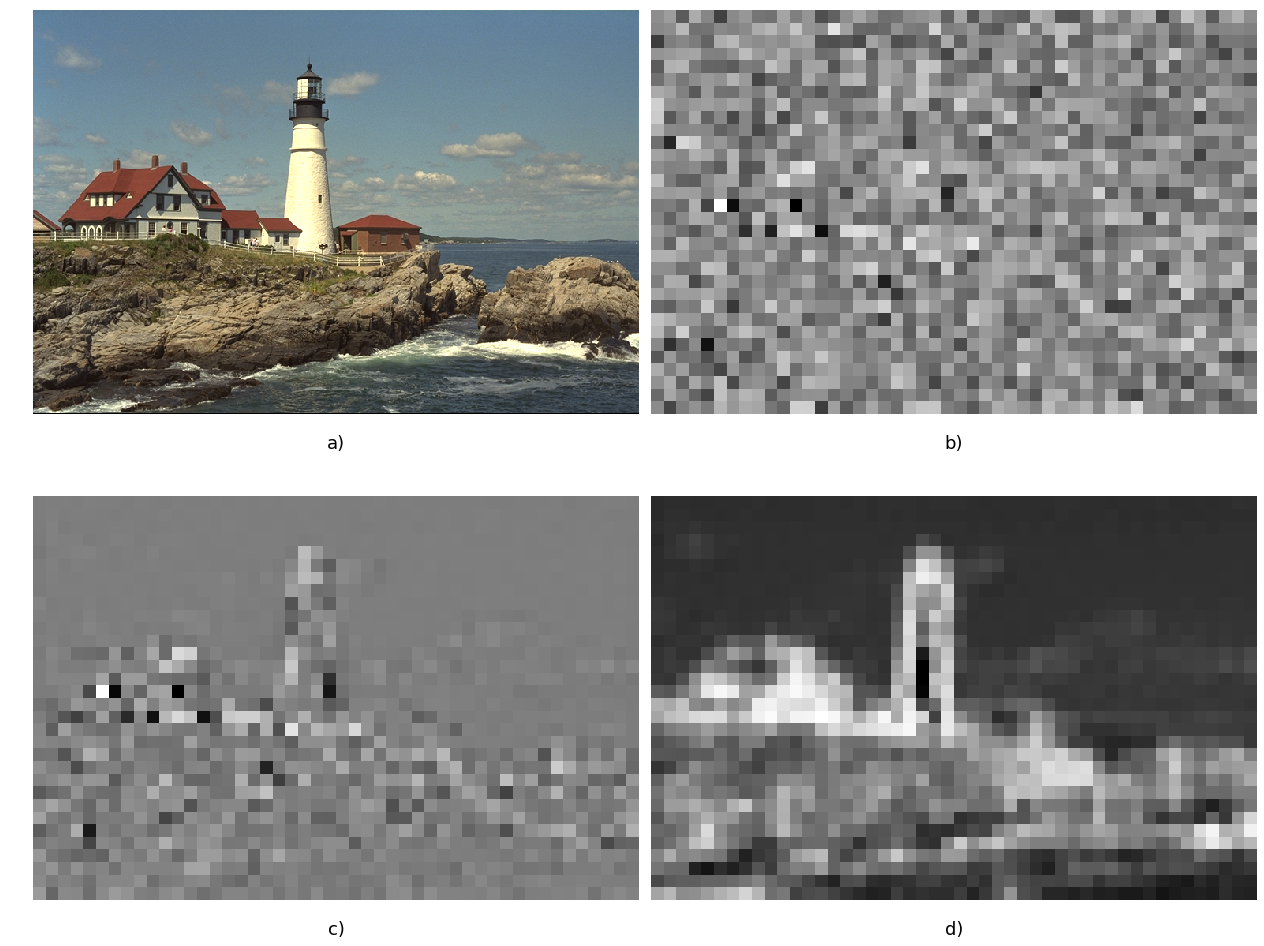

Ladder


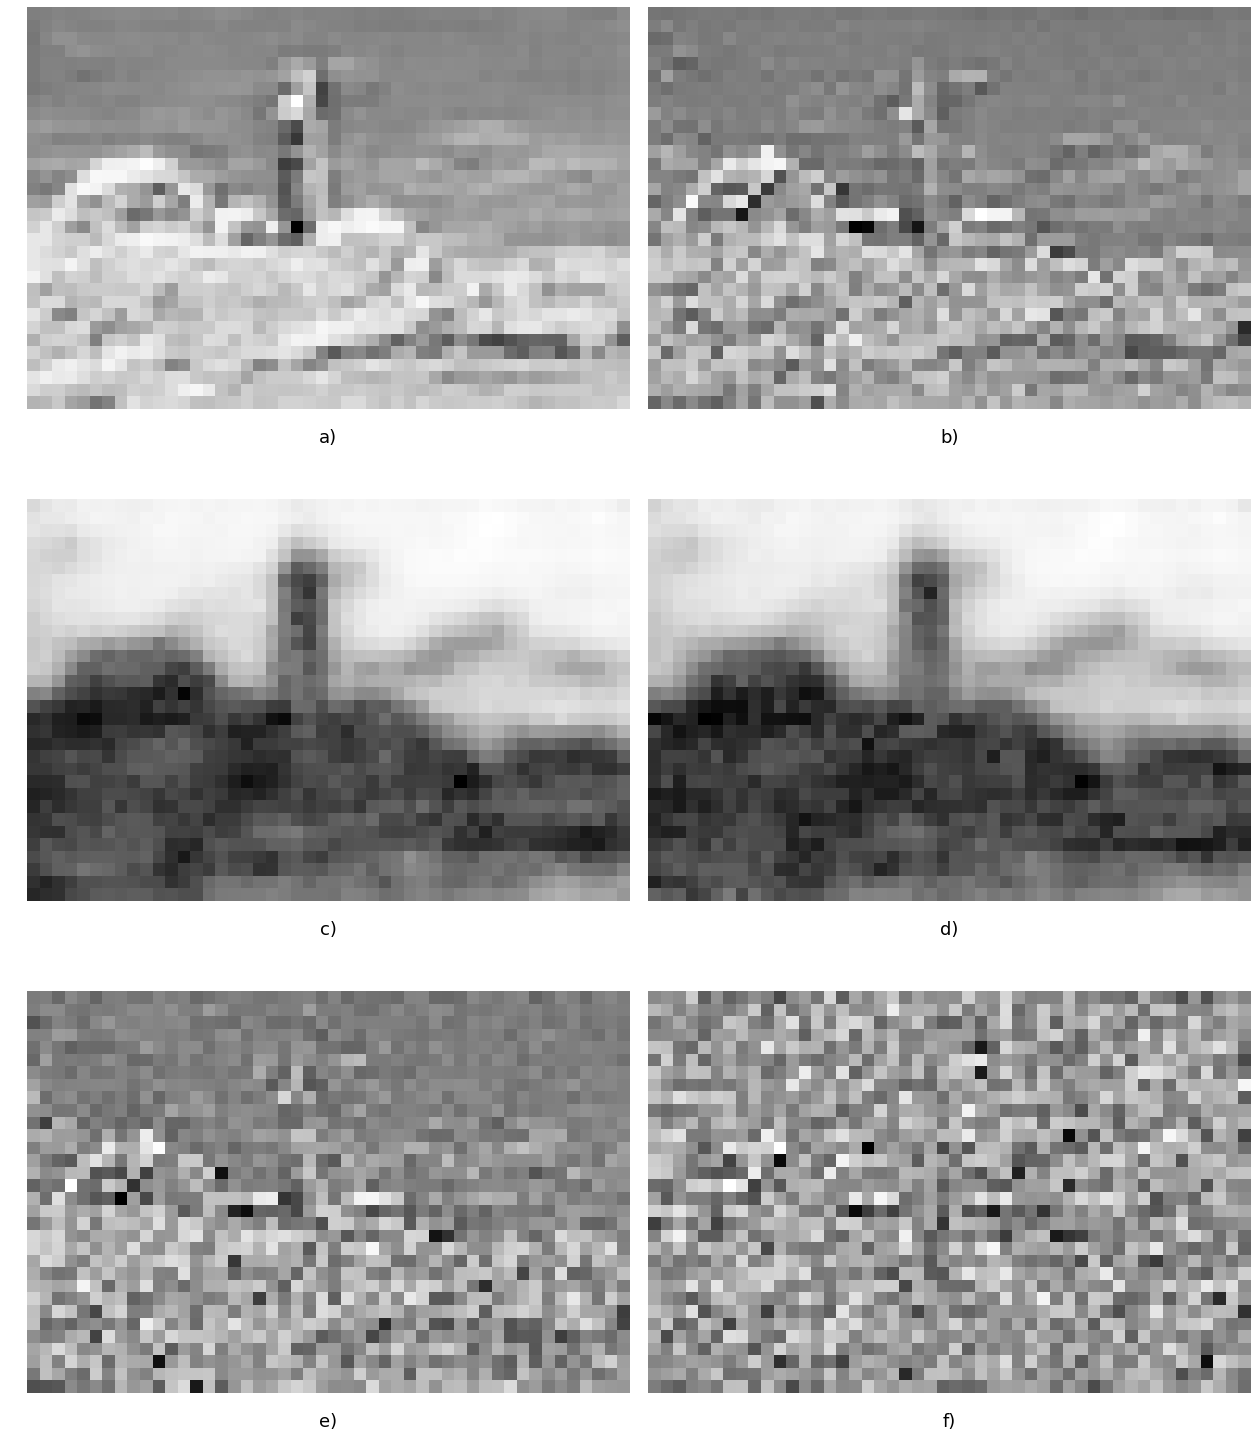

Gamma-Ladder


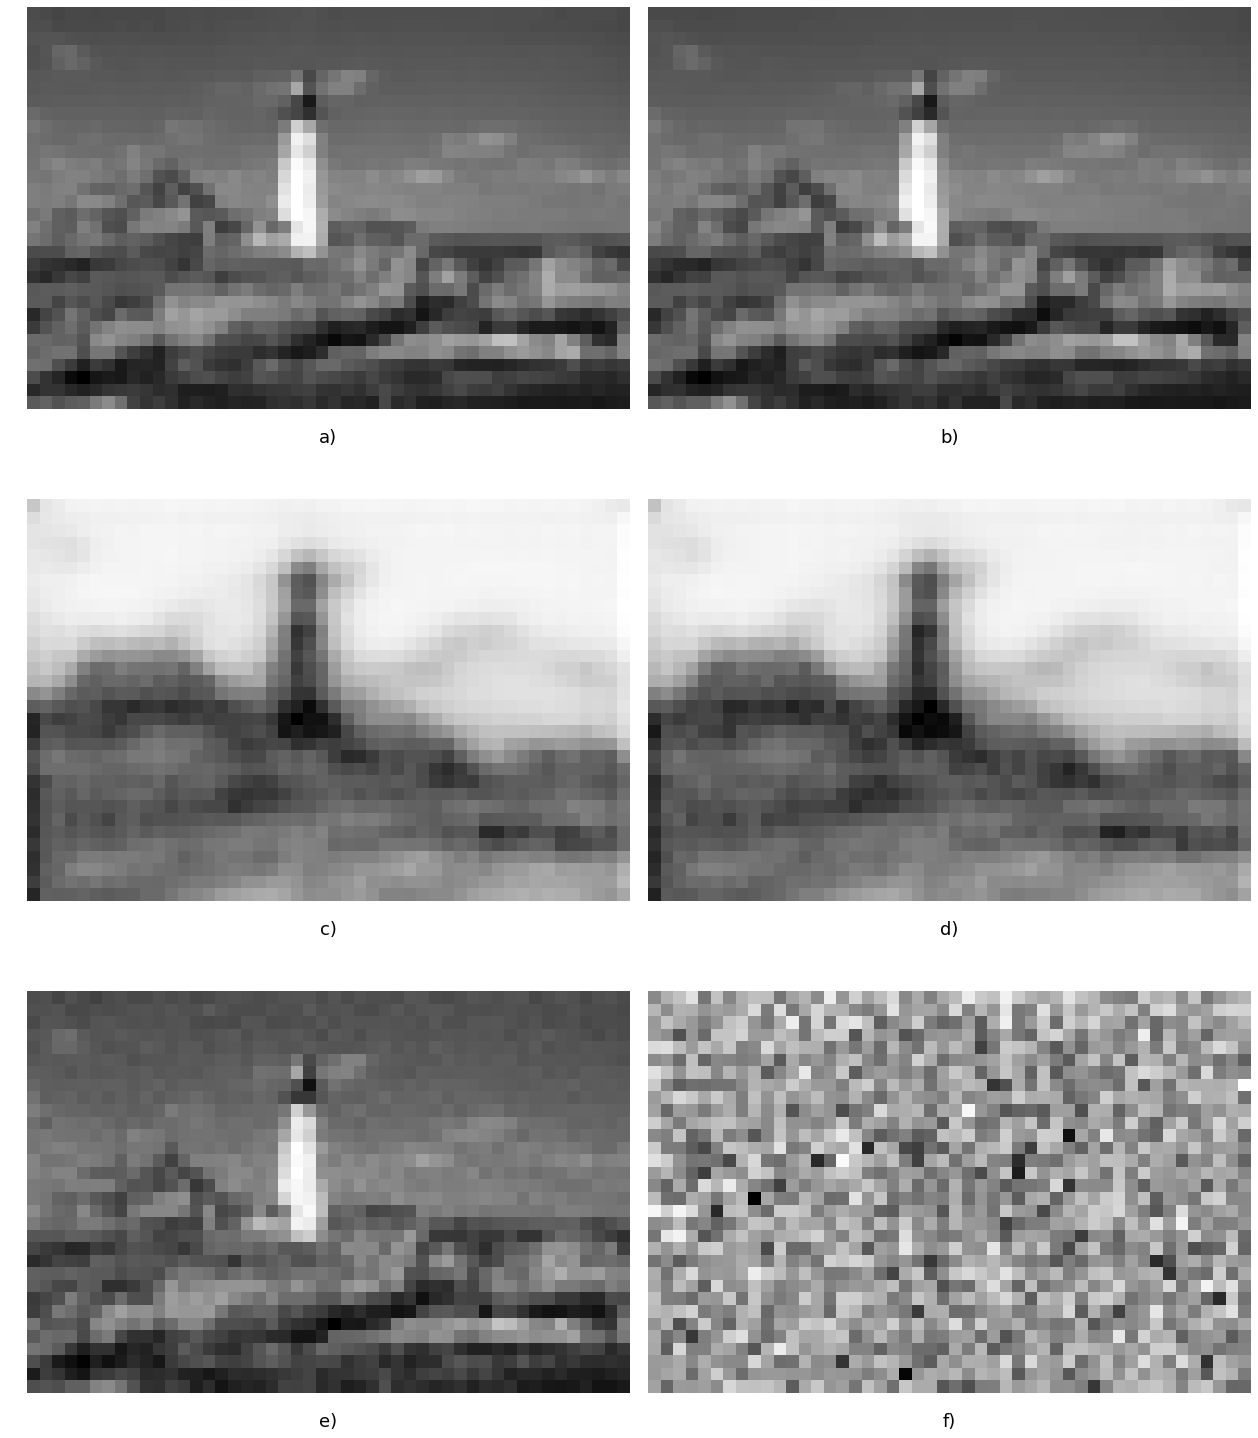

In [5]:
seed = 42

latent_effects_save_path = "../../img/plots/vae_latents/"

print("VAE")
vae_posterior_plot(vae_q, 
                   test_image, 
                   seed=seed, 
                   save_path=latent_effects_save_path + "vae_rand_posterior.png")
print("Ladder")
ladder_second_level_effect_plot(ladder_p1, 
                                ladder_q1, 
                                seed=seed, 
                                save_path=latent_effects_save_path + "ladder_rand_posterior.png")
print("Gamma-Ladder")
ladder_second_level_effect_plot(gamma_p1, 
                                gamma_q1, 
                                seed=seed, 
                                save_path=latent_effects_save_path + "gamma_rand_posterior.png")

In [ ]:
def ladder_comparison_latent_plot(l_p1, l_q1, l_p2, l_q2,
                                  g_p1, g_q1, g_p2, g_q2,
                                  show=True,
                                  save_path=None,
                                  title_fontsize=18,
                                  bins=200):
    
    sns.set_palette("muted")
    
    l_q1_loc = l_q1.loc.numpy().reshape([-1])
    l_q1_scale = l_q1.scale.numpy().reshape([-1])
    l_p1_loc = l_p1.loc.numpy().reshape([-1])
    l_p1_scale = l_p1.scale.numpy().reshape([-1])
    
    l_q2_loc = l_q2.loc.numpy().reshape([-1])
    l_q2_scale = l_q2.scale.numpy().reshape([-1])
    l_p2_loc = l_p2.loc.numpy().reshape([-1])
    l_p2_scale = l_p2.scale.numpy().reshape([-1])
    
    # Standardize the first level posterior by the prior
    l_q1_loc_std = (l_q1_loc - l_p1_loc) / l_p1_scale
    l_q1_scale_std = l_q1_scale / l_p1_scale
    
    g_q1_loc = g_q1.loc.numpy().reshape([-1])
    g_q1_scale = g_q1.scale.numpy().reshape([-1])
    g_p1_loc = g_p1.loc.numpy().reshape([-1])
    g_p1_scale = l_p1.scale.numpy().reshape([-1])
    
    g_q2_loc = g_q2.loc.numpy().reshape([-1])
    g_q2_scale = g_q2.scale.numpy().reshape([-1])
    g_p2_loc = g_p2.loc.numpy().reshape([-1])
    g_p2_scale = g_p2.scale.numpy().reshape([-1])
    
    # Standardize the first level posterior by the prior
    g_q1_loc_std = (g_q1_loc - g_p1_loc) / g_p1_scale
    g_q1_scale_std = g_q1_scale / g_p1_scale
    
    with tf.device("CPU:0"):
        l_kl1 = tf.reshape(tfd.kl_divergence(l_q1, l_p1), [-1]).numpy()
        l_kl2 = tf.reshape(tfd.kl_divergence(l_q2, l_p2), [-1]).numpy()
        
        g_kl1 = tf.reshape(tfd.kl_divergence(g_q1, g_p1), [-1]).numpy()
        g_kl2 = tf.reshape(tfd.kl_divergence(g_q2, g_p2), [-1]).numpy()
    

    # Plot stuff
    #white, dark, whitegrid, darkgrid, ticks
    #sns.set_style("ticks")
    
    # ----------------------------------------------------------------------------
    # Level 2 posterior comparison
    # ----------------------------------------------------------------------------
    fig = plt.figure(figsize=(17, 10))
    plt.subplots_adjust(left=0.02, bottom=0.03, right=0.98, top=0.97, wspace=0.05, hspace=0.2)
    
    ax = plt.subplot(221)
    plt.title("PLN 2nd Level Posterior Means", fontsize=title_fontsize)
    plt.hist(l_q2_loc, bins=bins, density=True)
    ax.axes.get_yaxis().set_visible(False)
    plt.xlim([-4, 4])
    
    ax = plt.subplot(222)
    plt.title("$\gamma$-PLN 2nd Level Posterior Means", fontsize=title_fontsize)
    plt.hist(g_q2_loc, bins=bins, density=True)
    ax.axes.get_yaxis().set_visible(False)
    plt.xlim([-4, 4])
    
    ax = plt.subplot(223)
    plt.title("PLN Standard 2nd Level Posterior Deviations", fontsize=title_fontsize)
    plt.hist(l_q2_scale, bins=bins, density=True)
    ax.axes.get_yaxis().set_visible(False)
    plt.xlim([0, 1])
    
    ax = plt.subplot(224)
    plt.title("$\gamma$-PLN 2nd Level Posterior Standard Deviations", fontsize=title_fontsize)
    plt.hist(g_q2_scale, bins=bins, density=True)
    ax.axes.get_yaxis().set_visible(False)
    plt.xlim([0, 1])

    if save_path is not None:
        plt.savefig(save_path + "/ladder_gamma_q2_comp.png")
  
    plt.show()
    
    plt.close()
    
    # ----------------------------------------------------------------------------
    # Level 1 Prior comparison
    # ----------------------------------------------------------------------------
    fig = plt.figure(figsize=(17, 10))
    plt.subplots_adjust(left=0.02, bottom=0.03, right=0.98, top=0.97, wspace=0.05, hspace=0.2)
    
    ax = plt.subplot(221)
    plt.title("PLN 1st Level Prior Means", fontsize=title_fontsize)
    plt.hist(l_p1_loc, bins=bins, density=True)
    ax.axes.get_yaxis().set_visible(False)
    plt.xlim([-6, 6])
    
    
    ax = plt.subplot(222)
    plt.title("$\gamma$-PLN 1st Level Prior Means", fontsize=title_fontsize)
    plt.hist(g_p1_loc, bins=bins, density=True)
    ax.axes.get_yaxis().set_visible(False)
    plt.xlim([-6, 6])
    
    
    ax = plt.subplot(223)
    plt.title("PLN Standard 1st Level Prior Deviations", fontsize=title_fontsize)
    plt.hist(l_p1_scale, bins=bins, density=True)
    ax.axes.get_yaxis().set_visible(False)
    plt.xlim([0, 1.6])
   
    
    ax = plt.subplot(224)
    plt.title("$\gamma$-PLN 1st Level Prior Standard Deviations", fontsize=title_fontsize)
    plt.hist(g_p1_scale, bins=bins, density=True)
    ax.axes.get_yaxis().set_visible(False)
    plt.xlim([0, 1.6])
  
    if save_path is not None:
        plt.savefig(save_path + "/ladder_gamma_p1_comp.png")
  
    plt.show()
    
    plt.close()
    
    # ----------------------------------------------------------------------------
    # Level 1 Posterior comparison
    # ----------------------------------------------------------------------------
    fig = plt.figure(figsize=(17, 10))
    plt.subplots_adjust(left=0.02, bottom=0.03, right=0.98, top=0.97, wspace=0.05, hspace=0.2)
    
    ax = plt.subplot(221)
    plt.title("PLN 1st Level Posterior Means", fontsize=title_fontsize)
    plt.hist(l_q1_loc, bins=bins, density=True)
    ax.axes.get_yaxis().set_visible(False)
    plt.xlim([-6, 6])
    
    
    ax = plt.subplot(222)
    plt.title("$\gamma$-PLN 1st Level Posterior Means", fontsize=title_fontsize)
    plt.hist(g_q1_loc, bins=bins, density=True)
    ax.axes.get_yaxis().set_visible(False)
    plt.xlim([-6, 6])
    
    
    ax = plt.subplot(223)
    plt.title("PLN Standard 1st Level Posterior Deviations", fontsize=title_fontsize)
    plt.hist(l_q1_scale, bins=bins, density=True)
    ax.axes.get_yaxis().set_visible(False)
    plt.xlim([0, 1.6])
   
    
    ax = plt.subplot(224)
    plt.title("$\gamma$-PLN 1st Level Posterior Standard Deviations", fontsize=title_fontsize)
    plt.hist(g_q1_scale, bins=bins, density=True)
    ax.axes.get_yaxis().set_visible(False)
    plt.xlim([0, 1.6])
    
    if save_path is not None:
        plt.savefig(save_path + "/ladder_gamma_q1_comp.png")
  
    plt.show()
    
    plt.close()
    
    # ----------------------------------------------------------------------------
    # Level 1 Standardized Posterior comparison
    # ----------------------------------------------------------------------------
    fig = plt.figure(figsize=(17, 10))
    plt.subplots_adjust(left=0.02, bottom=0.03, right=0.98, top=0.97, wspace=0.05, hspace=0.2)
    
    ax = plt.subplot(221)
    plt.title("PLN 1st Level Std. Posterior Means", fontsize=title_fontsize)
    plt.hist(l_q1_loc_std, bins=bins, density=True)
    ax.axes.get_yaxis().set_visible(False)
    plt.xlim([-4, 4])
    
    
    ax = plt.subplot(222)
    plt.title("$\gamma$-PLN 1st Level Std. Posterior Means", fontsize=title_fontsize)
    plt.hist(g_q1_loc_std, bins=bins, density=True)
    ax.axes.get_yaxis().set_visible(False)
    plt.xlim([-4, 4])
    
    
    ax = plt.subplot(223)
    plt.title("PLN Standard 1st Level Std. Posterior Deviations", fontsize=title_fontsize)
    plt.hist(l_q1_scale_std, bins=bins, density=True)
    ax.axes.get_yaxis().set_visible(False)
    plt.xlim([0, 2.5])
   
    
    ax = plt.subplot(224)
    plt.title("$\gamma$-PLN 1st Level Std. Posterior Standard Deviations", fontsize=title_fontsize)
    plt.hist(g_q1_scale_std, bins=bins, density=True)
    ax.axes.get_yaxis().set_visible(False)
    plt.xlim([0, 2.5])

    if save_path is not None:
        plt.savefig(save_path + "/ladder_gamma_std_q1_comp.png")
  
    plt.show()
    
    plt.close()
    
    # ----------------------------------------------------------------------------
    # KL Comparisons
    # ----------------------------------------------------------------------------
    fig = plt.figure(figsize=(17, 10))
    plt.subplots_adjust(left=0.02, bottom=0.03, right=0.98, top=0.97, wspace=0.05, hspace=0.2)
    
    ax = plt.subplot(221)
    plt.title("PLN Level 2 KL-Divergences", fontsize=title_fontsize)
    plt.hist(g_kl2, bins=bins, range=(0.3, 15), density=True, log=False)
    plt.hist(l_kl2, bins=bins, range=(0.3, 15), density=True, log=False)
    ax.axes.get_yaxis().set_visible(False)
    
    
    ax = plt.subplot(222)
    plt.title("$\gamma$-PLN Level 2 KL-Divergences", fontsize=title_fontsize)
    plt.hist(g_kl2, bins=bins, density=True, log=True)
    ax.axes.get_yaxis().set_visible(False)
    
    
    ax = plt.subplot(223)
    plt.title("PLN Level 1 KL-Divergences", fontsize=title_fontsize)
    plt.hist(g_kl1, bins=bins, range=(0.3, 15), density=True, log=False)
    plt.hist(l_kl1, bins=bins, range=(0.3, 15), density=True, log=False)
    ax.axes.get_yaxis().set_visible(False)
   
    
    ax = plt.subplot(224)
    plt.title("$\gamma$-PLN Level 1 KL-Divergences", fontsize=title_fontsize)
    plt.hist(g_kl1, bins=bins, density=True, log=True)
    ax.axes.get_yaxis().set_visible(False)

    if save_path is not None:
        plt.savefig(save_path + "/ladder_gamma_kl_comp.png")
  
    plt.show()
    
    plt.close()
    
    # ----------------------------------------------------------------------------
    # SNR Comparisons
    # ----------------------------------------------------------------------------
    fig = plt.figure(figsize=(17, 10))
    plt.subplots_adjust(left=0.02, bottom=0.03, right=0.98, top=0.97, wspace=0.05, hspace=0.2)
    
    ax = plt.subplot(221)
    plt.title("PLN Level Posterior SNR", fontsize=title_fontsize)
    plt.hist(np.abs(l_q2_loc) / l_q2_scale, bins=bins, density=True, log=True)
    ax.axes.get_yaxis().set_visible(False)
    
    
    ax = plt.subplot(222)
    plt.title("$\gamma$-PLN Level Posterior SNR", fontsize=title_fontsize)
    plt.hist(np.abs(g_q2_loc) / g_q2_scale, bins=bins, density=True, log=True)
    ax.axes.get_yaxis().set_visible(False)
    
    ax = plt.subplot(223)
    plt.title("PLN Level 1 Prior-Standardized Posterior SNR", fontsize=title_fontsize)
    plt.hist(np.abs(l_q1_loc_std) / l_q1_scale_std, bins=bins, density=True, log=True)
    ax.axes.get_yaxis().set_visible(False)
   
    
    ax = plt.subplot(224)
    plt.title("$\gamma$-PLN Level 1 Prior-Standardized Posterior SNR", fontsize=title_fontsize)
    plt.hist(np.abs(g_q1_loc_std) / g_q1_scale_std, bins=bins, density=True, log=True)
    ax.axes.get_yaxis().set_visible(False)
    
    if save_path is not None:
        plt.savefig(save_path + "ladder_gamma_snr_comp.png")
    
    plt.show()
    
    plt.close()

In [ ]:
sns.reset_orig()

ladder_comparison_latent_plot(ladder_p1, ladder_q1, ladder_p2, ladder_q2,
                              gamma_p1, gamma_q1, gamma_p2, gamma_q2,
                              bins=150,
                              save_path="../../img/plots/vae_latents/")

In [65]:
help(plt.subplots_adjust)

Help on function subplots_adjust in module matplotlib.pyplot:

subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    Tune the subplot layout.
    
    The parameter meanings (and suggested defaults) are::
    
      left  = 0.125  # the left side of the subplots of the figure
      right = 0.9    # the right side of the subplots of the figure
      bottom = 0.1   # the bottom of the subplots of the figure
      top = 0.9      # the top of the subplots of the figure
      wspace = 0.2   # the amount of width reserved for space between subplots,
                     # expressed as a fraction of the average axis width
      hspace = 0.2   # the amount of height reserved for space between subplots,
                     # expressed as a fraction of the average axis height
    
    The actual defaults are controlled by the rc file



In [9]:
def vae_aggregate_posterior_plot(q, bins=100):
    
    with tf.device("CPU:0"):
        q_loc = tf.reshape(q.loc[0, ...], [-1]).numpy()
        q_scale = tf.reshape(q.scale[0, ...], [-1]).numpy()

    plt.figure(figsize=(17, 8))
    plt.subplot(121)
    plt.hist(q_loc, bins=bins, log=True)
    plt.subplot(122)
    plt.hist(q_scale, bins=bins, log=True)
    plt.show()

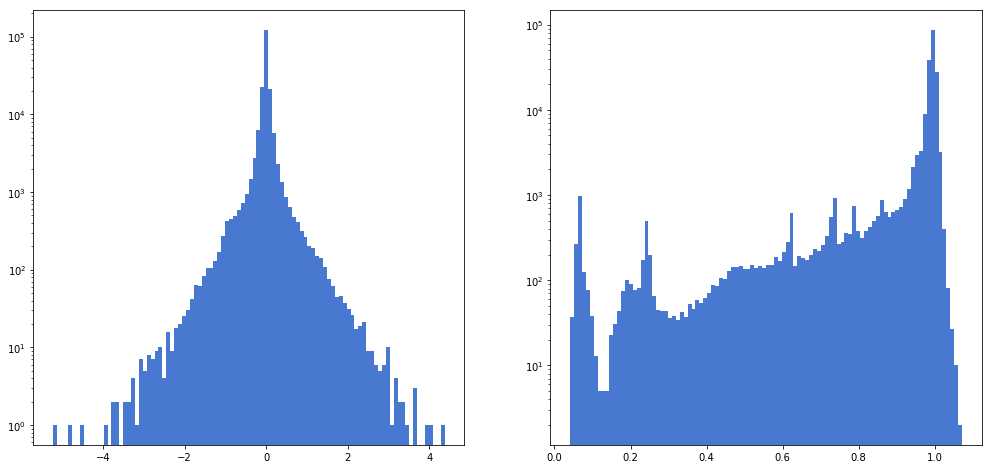

In [10]:
vae_aggregate_posterior_plot(vae_q)

# Image Reconstruction Plots

In [72]:
#4 10 17

# 8 5

def reconstruction_comparison_plots(image_folders, 
                                    image_number, 
                                    save_path, 
                                    show=True, 
                                    title_fontsize=24,
                                    kodak_im_format="kodim{:02d}.png"):
    
    comparison_image_paths = [image_folder + "/" + kodak_im_format.format(image_number)
                              for image_folder in image_folders]
    
    comparison_images = [load_and_process_image(im_path) for im_path in comparison_image_paths]
    
    if len(image_folders) == 2:
        
        plt.figure(figsize=(10, 13))
        plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1, wspace=0, hspace=0.03)
        ax = plt.subplot(211)
        plt.imshow(comparison_images[0])
        plt.axis('off')
        
        ax = plt.subplot(212)
        plt.imshow(comparison_images[1])
        plt.axis('off')
        
    elif len(image_folders) == 4:
        plt.figure(figsize=(10, 15))
        plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1, wspace=0.01, hspace=0.03)
        
        # top left
        ax = plt.subplot(221)
        plt.imshow(comparison_images[0])
        plt.axis('off')
        
        # top right
        ax = plt.subplot(222)
        plt.imshow(comparison_images[1])
        plt.axis('off')
        
        # bottom left
        ax = plt.subplot(223)
        plt.imshow(comparison_images[2])
        plt.axis('off')
        
        # bottom right
        ax = plt.subplot(224)
        plt.imshow(comparison_images[3])
        plt.axis('off')
        
    else:
        print("no")

    if save_path is not None:
        plt.savefig(save_path)
  
    if show:
        plt.show()
    
    plt.close()

In [76]:
# GAmma Ladder network reconstructions

reconstruction_comparison_plots(
    ["/scratch/gf332/data/kodak_miracle/ladder_128_24_01_learn_log_gamma/",
     "/scratch/gf332/data/kodak_miracle/ladder_128_24_1_learn_log_gamma/"],
     8,
     show=False,
     save_path="/homes/gf332/miracle-compession/img/plots/reconstructions/log_gamma_01_1_k08.png")

reconstruction_comparison_plots(
    ["/scratch/gf332/data/kodak_miracle/ladder_128_24_3_learn_log_gamma/",
     "/scratch/gf332/data/kodak_miracle/ladder_128_24_10_learn_log_gamma/"],
     5,
     show=False,
     save_path="/homes/gf332/miracle-compession/img/plots/reconstructions/log_gamma_3_10_k05.png")

reconstruction_comparison_plots(
    ["/scratch/gf332/data/kodak_miracle/ladder_128_24_01_learn_log_gamma/",
     "/scratch/gf332/data/kodak_miracle/ladder_128_24_1_learn_log_gamma/"],
     5,
     show=False,
     save_path="/homes/gf332/miracle-compession/img/plots/reconstructions/log_gamma_01_1_k05.png")

reconstruction_comparison_plots(
    ["/scratch/gf332/data/kodak_miracle/ladder_128_24_01_learn_log_gamma/",
     "/scratch/gf332/data/kodak_miracle/ladder_128_24_1_learn_log_gamma/",
     "/scratch/gf332/data/kodak_miracle/ladder_128_24_3_learn_log_gamma/",
     "/scratch/gf332/data/kodak_miracle/ladder_128_24_10_learn_log_gamma/"],
     4,
     show=False,
     save_path="/homes/gf332/miracle-compession/img/plots/reconstructions/log_gamma_01_1_3_10_k04.png")

reconstruction_comparison_plots(
    ["/scratch/gf332/data/kodak_miracle/ladder_128_24_01_learn_log_gamma/",
     "/scratch/gf332/data/kodak_miracle/ladder_128_24_1_learn_log_gamma/",
     "/scratch/gf332/data/kodak_miracle/ladder_128_24_3_learn_log_gamma/",
     "/scratch/gf332/data/kodak_miracle/ladder_128_24_10_learn_log_gamma/"],
     10,
     show=False,
     save_path="/homes/gf332/miracle-compession/img/plots/reconstructions/log_gamma_01_1_3_10_k10.png")

reconstruction_comparison_plots(
    ["/scratch/gf332/data/kodak_miracle/ladder_128_24_01_learn_log_gamma/",
     "/scratch/gf332/data/kodak_miracle/ladder_128_24_1_learn_log_gamma/",
     "/scratch/gf332/data/kodak_miracle/ladder_128_24_3_learn_log_gamma/",
     "/scratch/gf332/data/kodak_miracle/ladder_128_24_10_learn_log_gamma/"],
     17,
     show=False,
     save_path="/homes/gf332/miracle-compession/img/plots/reconstructions/log_gamma_01_1_3_10_k17.png")

In [77]:
# Ladder network reconstructions

reconstruction_comparison_plots(
    ["/scratch/gf332/data/kodak_miracle/ladder_128_24_003/",
     "/scratch/gf332/data/kodak_miracle/ladder_128_24_01/"],
     8,
     show=False,
     save_path="/homes/gf332/miracle-compession/img/plots/reconstructions/pln_003_01_k08.png")

reconstruction_comparison_plots(
    ["/scratch/gf332/data/kodak_miracle/ladder_128_24_03/",
     "/scratch/gf332/data/kodak_miracle/ladder_128_24_1/"],
     5,
     show=False,
     save_path="/homes/gf332/miracle-compession/img/plots/reconstructions/pln_03_1_k05.png")

reconstruction_comparison_plots(
    ["/scratch/gf332/data/kodak_miracle/ladder_128_24_003/",
     "/scratch/gf332/data/kodak_miracle/ladder_128_24_01/"],
     5,
     show=False,
     save_path="/homes/gf332/miracle-compession/img/plots/reconstructions/pln_003_01_k05.png")

#=============

reconstruction_comparison_plots(
    ["/scratch/gf332/data/kodak_miracle/ladder_128_24_003/",
     "/scratch/gf332/data/kodak_miracle/ladder_128_24_01/",
     "/scratch/gf332/data/kodak_miracle/ladder_128_24_03/",
     "/scratch/gf332/data/kodak_miracle/ladder_128_24_1/"],
     4,
     show=False,
     save_path="/homes/gf332/miracle-compession/img/plots/reconstructions/pln_003_01_03_1_k04.png")

reconstruction_comparison_plots(
    ["/scratch/gf332/data/kodak_miracle/ladder_128_24_003/",
     "/scratch/gf332/data/kodak_miracle/ladder_128_24_01/",
     "/scratch/gf332/data/kodak_miracle/ladder_128_24_03/",
     "/scratch/gf332/data/kodak_miracle/ladder_128_24_1/"],
     10,
     show=False,
     save_path="/homes/gf332/miracle-compession/img/plots/reconstructions/pln_003_01_03_1_k10.png")

reconstruction_comparison_plots(
    ["/scratch/gf332/data/kodak_miracle/ladder_128_24_003/",
     "/scratch/gf332/data/kodak_miracle/ladder_128_24_01/",
     "/scratch/gf332/data/kodak_miracle/ladder_128_24_03/",
     "/scratch/gf332/data/kodak_miracle/ladder_128_24_1/"],
     17,
     show=False,
     save_path="/homes/gf332/miracle-compession/img/plots/reconstructions/pln_003_01_03_1_k17.png")

# Generate Distribution data for PLNs

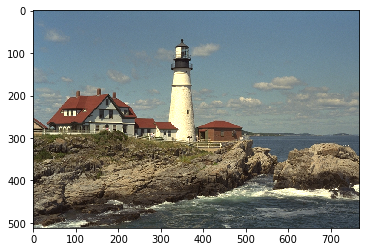

In [5]:
kodak_path = "../../data/kodak/"
kodak_image_paths = glob.glob(kodak_path + "/*.png")
kodak_image_paths.sort()

im = load_and_process_image(kodak_image_paths[20])
plt.imshow(im)


test_im = tf.convert_to_tensor(im[None, ...])
latents = vae.encode(test_im)

res = vae.decode(latents)

In [6]:
p1_loc = vae.latent_priors[0].loc[0]
p1_scale = vae.latent_priors[0].scale[0]
q1_loc = vae.latent_posteriors[0].loc[0]
q1_scale = vae.latent_posteriors[0].scale[0]

p2_loc = vae.latent_priors[1].loc[0]
p2_scale = vae.latent_priors[1].scale[0]
q2_loc = vae.latent_posteriors[1].loc[0]
q2_scale = vae.latent_posteriors[1].scale[0]

p1 = vae.latent_priors[0]
q1 = vae.latent_posteriors[0]
p2 = vae.latent_priors[1]
q2 = vae.latent_posteriors[1]

vae_latents_dir = "../../data/vae_latents/ladder_128_24_01/"

np.save(vae_latents_dir + "q1_loc.npy", q1_loc.numpy())
np.save(vae_latents_dir + "q1_scale.npy", q1_scale.numpy())

np.save(vae_latents_dir + "p1_loc.npy", p1_loc.numpy())
np.save(vae_latents_dir + "p1_scale.npy", p1_scale.numpy())

np.save(vae_latents_dir + "q2_loc.npy", q2_loc.numpy())
np.save(vae_latents_dir + "q2_scale.npy", q2_scale.numpy())

# Generate distribution data for Single level VAE

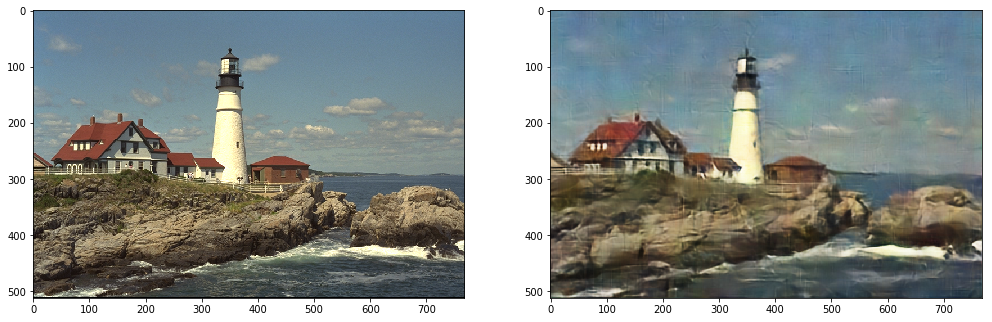

In [11]:
kodak_path = "../../data/kodak/"
kodak_image_paths = glob.glob(kodak_path + "/*.png")
kodak_image_paths.sort()

im = load_and_process_image(kodak_image_paths[20])

vae = vae[0]

test_im = tf.convert_to_tensor(im[None, ...])
latents = vae.encode(test_im)

res = vae.decode(latents)

plt.figure(figsize=(17, 8))
plt.subplot(121)
plt.imshow(im)

plt.subplot(122)
plt.imshow(res[0])

In [26]:
vae_latents_dir = "../../data/vae_latents/two_stage_128_01/"

np.save(vae_latents_dir + "q_loc.npy", vae.posterior.loc.numpy())
np.save(vae_latents_dir + "q_scale.npy", vae.posterior.scale.numpy())